In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import scipy.stats as stats
from matplotlib.ticker import FuncFormatter
import scipy.optimize as op
import os
from nltk import flatten
import scipy.stats as st
import math
import random

We implement some functions from SME (single station) and SME (multiple stations).

In [2]:
def get_station_index(loc_codes, i):
    """Find the index of given station id i in the array location codes
    
    :param i: station id
    :return ind: the inderx
    """
    
    return loc_codes.index(i)

In [3]:
def process_times_mut(dep_times, arr_times):
    """
    Return the event times in both departure process and arrival process at station i, before the last event time
    observed in departure process.
    
    : param dep_times: a 1-D array, the departure times from station i
    : param arr_times: a 1-D array, the arrival times to station i
    
    : return event_times: a dictionary, storing all relevant event times
    """
    
    event_times = {}
    
    event_times["departure"] = dep_times
    event_times["arrival"] = arr_times[: prev_event(arr_times, dep_times[-1])]
    
    return event_times  

In [4]:
def B_i(theta, dep_times, arr_times):
    """
    Finds the array of function B_i, for all event times in process i
    
    : param theta: a 1-D array of length 2, which stores theta and theta'
    : param dep_times, a 1-D array, the event times observed in process i
    : param arr_times, a 1-D array, the event times observed in process j
    
    : return B: a 1D array
    """
    
    B = np.zeros(len(dep_times))
    ind = prev_event(arr_times, dep_times[0])
    
    B[0] = np.sum(np.exp(- theta[1] * (dep_times[0] - arr_times[:ind])))
    
    for h in range(1, len(dep_times)):
        B[h] = np.exp(-theta[1] * (dep_times[h] - dep_times[h-1])) * B[h-1] 
        B[h] += np.sum(np.exp(- theta[1] * (dep_times[h] - arr_times[ind:prev_event(arr_times, dep_times[h])])))
        ind = prev_event(arr_times, dep_times[h])
        
    return B

In [5]:
def A_i(theta, dep_times):
    """
    Finds the array of function A_i, from 1st event to hth event in process i
    
    : param theta: a 1-D array of length 2, which stores theta and theta'
    : param dep_times, a 1-D array, the event times observed in process i
    
    : return A: a 1-D array
    """
   
    A = np.zeros(len(dep_times))
    
    for h in range(1, len(dep_times)):
        A[h] = np.exp(-theta[0]*(dep_times[h] - dep_times[h-1]))*(1+A[h-1])
        
    return A

In [6]:
def mutual_log_likelihood(event_times, beta, theta, lambda_b): 
    """
    Finds the log-likelihood of the mutually exciting process at station i
    
    : param event_times: a dictionary, the event times in all processes \
      that occurred before the last event in process i 
    : param beta: a 1-D array of length 2, which stores beta and beta'
    : param theta: a 1-D array of length 2, which stores theta and theta'
    : param lambda_b: a real number, the baseline intensity of station i
    
    : return res: a real number, the log likelihood
    """
    
    arr_times = event_times["arrival"]
    dep_times = event_times["departure"]
    if len(arr_times) == 0:
        raise Exception("Arrival times null")
    
    ratio = beta/theta
    T = dep_times[-1]
    
    A = A_i(theta, dep_times)
    B = B_i(theta, dep_times, arr_times)
    
    first_sum = np.sum(np.log(lambda_b + beta[0]*A + beta[1]*B))
    second_sum = ratio[0] * np.sum(np.exp(-theta[0]*(T - dep_times)) - 1)
    third_sum = 0
    ind = prev_event(arr_times, T)
    if ind != 0:
        third_sum += ratio[1] * np.sum(np.exp(-theta[1]*(T - arr_times[: ind])) - 1)
    res = first_sum + second_sum + third_sum - lambda_b*T
    
    return res

In [7]:
def mutual_comp(t, event_times, beta, theta, lambda_b): 
    
    arr_times = event_times["arrival"]
    dep_times = event_times["departure"]
    if len(arr_times) == 0:
        raise Exception("Arrival times null")
    
    ratio = beta/theta
    
    second_sum = 0
    third_sum = 0
    
    ind_dep = prev_event(dep_times, t)
    if ind_dep != 0:
        second_sum += ratio[0] * np.sum(np.exp(-theta[0]*(t - dep_times[: ind_dep])) - 1)
        
    ind_arr = prev_event(arr_times, t)
    if ind_arr != 0:
        third_sum += ratio[1] * np.sum(np.exp(-theta[1]*(t - arr_times[: ind_arr])) - 1)
    res = lambda_b*t - second_sum - third_sum 
    
    return res

In [8]:
def prev_event(times, T):
    """
    Return the event times in process j that happens before event time T in process i.
    : param times: an n-dimensional array, the full event times in process j
    : param T: a number, one event time in process i
    
    : return k: a number, the index of the last event time in process j happened before T in process i
    """
    
    return np.searchsorted(times, T, side='right')

In [9]:
def process_times(location_codes, times, i):
    """
    Return the departure and arrival times observed at station j = 1, ..., m, before the last event time
    observed in departure process at station i.
    
    : param location_codes: a list of length M, the location codes of all M stations, with i as the first.
    : param times: a dictionary, storing the departure and arrival times from station j = 1, ..., M as values, \
    and the location codes of corresponding stations as keys.
    : param i: the index of the station being studied
    
    : return times: a dictionary, storing all relevant event times
    """
    
    ii = get_station_index(location_codes, i)
    arr_times = times['arrival']
    dep_times = times['departure']
    T = dep_times[i][-1]
    ind_list = []
    ind1_list = []
    new_times = {}
    new_deptimes={}
    new_arrtimes={}
    
    for j in range(len(location_codes)):
        ind = prev_event(dep_times[location_codes[j]], T)
        if j != ii and ind != 0:
            new_deptimes[location_codes[j]] = dep_times[location_codes[j]][:ind]
        
        if ind == 0:
            ind_list.append(location_codes[j])
            new_deptimes[location_codes[j]] = np.array([])
        
        if j == ii:
            new_deptimes[location_codes[j]] = dep_times[location_codes[j]]
        
        ind1 = prev_event(arr_times[location_codes[j]], T)
        if ind1 != 0:
            new_arrtimes[location_codes[j]] = arr_times[location_codes[j]][:ind1]
        
        if ind1 == 0:
            ind1_list.append(location_codes[j])
            new_arrtimes[location_codes[j]] = np.array([])
     
    new_times['arrival'] = new_arrtimes
    new_times['departure'] = new_deptimes
    
    return new_times, ind_list, ind1_list

In [10]:
def kappa_fun(dist, k):
    
    return np.exp(-k * dist)

In [11]:
def A_ii(theta, times_i):
    """
    Finds the array of function A_i, from 1st event to hth event in process i
    
    : param theta: a real number
    : param times_i, a 1-D array, the event times observed in process i
    
    : return A: a 1D array
    """
   
    A = np.zeros(len(times_i))
    
    for h in range(1, len(times_i)):
        A[h] = np.exp(-theta*(times_i[h] - times_i[h-1]))*(1+A[h-1])
        
    return A

In [12]:
def A_ij(theta, times_i, times_j):
    """
    Finds the array of function A_ij, for all event times in process j = 1, ..., M
    
    : param theta: a real number
    : param times_i, a 1-D array, the event times observed in process i
    : param times_j, a 1-D array, the event times observed in process j
    
    : return B: a 1-D array
    """
    
    B = np.zeros(len(times_i))
    ind = prev_event(times_j, times_i[0])
    
    B[0] = np.sum(np.exp(- theta * (times_i[0] - times_j[:ind])))
    
    for h in range(1, len(times_i)):
        B[h] = np.exp(-theta * (times_i[h] - times_i[h-1])) * B[h-1] 
        new_ind = prev_event(times_j, times_i[h])
        if ind != new_ind:
            B[h] += np.sum(np.exp(- theta * (times_i[h] - times_j[ind:new_ind])))
            ind = new_ind#prev_event(times_j, times_i[h])
        
    return B

In [13]:
def excitation_j(theta, t, times_j):
    """
    Finds the array of function excitation_j, for all event times in process j = 1, ..., M
    
    : param theta: a real number, thetaj
    : param times_i, a 1-D array, the event times observed in process i
    : param times_j, a 1-D array, the event times observed in process j
    
    : return Ej: a 1-D array
    """
    #Ej = 0
    ind = prev_event(times_j, t)
    Ej = np.zeros(ind)
    if ind != 0:
            Ej = np.exp(-theta*(t - times_j[0:ind])) - 1
    #for i in range(ind):
        #Ej += np.exp(-theta*(t - times_j[i])) - 1
    
    return Ej

In [14]:
def seven_log_likelihood(location_codes, event_times, beta_dep, theta_dep, beta_arr, theta_arr, 
                        k_dep, k_arr, lambda_b, dist, i): 
    """
    Finds the log-likelihood of the mutually exciting process between stations
    
    : param location_codes: a list of length M, the location codes of all M stations with i as the first
    : param event_times: a dictionary, the event times in all processes \
      that occurred before the last event in process i 
    : param beta: a real number
    : param theta: a real number
    : param k: a real number
    : param dist: a 1-D array of length M, which stores the distances of each station
    : param lambda_b: a real number, the baseline intensity of station i
    : param i: the index of the station being studied
    
    : return A: a real number, the baseline intensity of station i
    """
    ind = get_station_index(location_codes, i)
    arr_times = event_times["arrival"]
    dep_times = event_times["departure"]
    times_i = dep_times[i]
    
    kappa_dep = kappa_fun(dist, k_dep)
    kappa_arr = kappa_fun(dist, k_arr)
    ratio_dep = kappa_dep*beta_dep/theta_dep
    ratio_arr = kappa_arr*beta_arr/theta_arr
    T = times_i[-1]
    
    #Depature at station i
    A = A_ii(theta_dep, times_i)
    A = kappa_dep[ind]*beta_dep*A
    ex_terms = ratio_dep[ind] * np.sum(excitation_j(theta_dep, T, times_i))
    #Arrival at station i
    A += kappa_arr[ind]*beta_arr*A_ij(theta_arr, times_i, arr_times[location_codes[ind]])
    ex_terms += ratio_arr[ind] * np.sum(excitation_j(theta_arr, T, arr_times[location_codes[ind]]))
    
    for j in range(len(location_codes)):
        if j != ind:
            #Depature at station j
            A += kappa_dep[j] * beta_dep * A_ij(theta_dep, times_i, dep_times[location_codes[j]])
            ex_terms += ratio_dep[j] * np.sum(excitation_j(theta_dep, T, dep_times[location_codes[j]]))
            #Arrival at station j
            A += kappa_arr[j] * beta_arr * A_ij(theta_arr, times_i, arr_times[location_codes[j]])
            ex_terms += ratio_arr[j] * np.sum(excitation_j(theta_arr, T, arr_times[location_codes[j]]))
    
    res = np.sum(np.log(lambda_b +A)) + ex_terms - lambda_b*T
    
    return res

In [15]:
def seven_comp(t, location_codes, event_times, beta_dep, theta_dep, beta_arr, theta_arr, k_dep, k_arr, lambda_b, dist, i): 
    
    arr_times = event_times["arrival"]
    dep_times = event_times["departure"]
    times_i = arr_times[i]
    kappa_dep = kappa_fun(dist, k_dep)
    kappa_arr = kappa_fun(dist, k_arr)
    ratio_dep = kappa_dep*beta_dep/theta_dep
    ratio_arr = kappa_arr*beta_arr/theta_arr
    
    ex_terms = 0
    
    for j in range(len(location_codes)):
        times_dep = dep_times[location_codes[j]]
        times_arr = arr_times[location_codes[j]]
        ind_dep = prev_event(times_dep, t)
        ind_arr = prev_event(times_arr, t)
        
        if ind_dep != 0:
            ex_terms += ratio_dep[j] * np.sum(excitation_j(theta_dep, t, times_dep[0:ind_dep]))
        if ind_arr != 0:
            ex_terms += ratio_arr[j] * np.sum(excitation_j(theta_arr, t, times_arr[0:ind_arr]))
    
    res = lambda_b*t - ex_terms 
    
    return res

In [16]:
def thres_fun(dist, thres, loc_codes):
    new_dist = dist.copy()
    new_loc_codes = np.asarray(loc_codes).copy()
    
    index = [i for i in range(len(dist)) if dist[i] > thres]
    new_dist[index] = -1
    new_loc_codes[index] = -1
    new_dist = [i for i in new_dist if i != -1]
    new_loc_codes = [i for i in new_loc_codes if i != -1]
    
    return np.asarray(new_dist), new_loc_codes

We read the departure and arrival data at each station from saved folder.

In [17]:
station_data = pd.read_csv("./santander_locations.csv")
loc_codes = list(station_data['Station.Id'].to_numpy())
all_times = {}
all_dep = {}
all_arr = {}

for i in range(808):
    loc = loc_codes[i]
    path_dep = f"./sortdep/Station{loc}"
    data_files_dep = os.listdir(path_dep)
    data_files = os.listdir(path_dep)
    path_arr = f"./sortarr/Station{loc}"
    data_files_arr = os.listdir(path_arr)

    bike_dep = {file: pd.read_csv(path_dep + '/' + file)
             for file in data_files_dep}  
    bike_arr = {file: pd.read_csv(path_arr + '/' + file)
             for file in data_files_arr}  

    for names in bike_dep.keys():
        del bike_dep[names]["Unnamed: 0"]
        del bike_arr[names]["Unnamed: 0"]
    
    dep_times = {}
    arr_times = {}

    for names in bike_dep.keys():
        if names != '.DS_Store':
            df_dep = bike_dep[names]
            df_dep = df_dep['start_t']
            dep_times[names] = df_dep.values.tolist()
        
            df_arr = bike_arr[names]
            df_arr = df_arr['end_t']
            arr_times[names] = df_arr.values.tolist()
            
    dep_times_list = np.array(sorted(flatten(list(dep_times.values())))) 
    arr_times_list = np.array(sorted(flatten(list(arr_times.values()))))
    all_dep[loc] = dep_times_list
    all_arr[loc] = arr_times_list

all_times['departure'] = all_dep
all_times['arrival'] = all_arr
loc_codes0 = loc_codes

FileNotFoundError: [Errno 2] No such file or directory: './santander_locations.csv'

In [ ]:
list(bike_dep.keys())[0]

We use a train/test split ratio of 0.75, taking the first 12 weeks as training data, and the rest as test data. We read and split train/test sets.

In [18]:
station_data = pd.read_csv("../Data/santander_locations.csv")
loc_codes = list(station_data['Station.Id'].to_numpy())
train_times = {}
all_train_dep = {}
all_train_arr = {}
test_times = {}
all_test_dep = {}
all_test_arr = {}

for i in range(808):
    loc = loc_codes[i]
    path_dep = f"../Processed_Data/sortdep/Station{loc}"
    data_files_dep = os.listdir(path_dep)
    data_files = os.listdir(path_dep)
    path_arr = f"../Processed_Data/sortarr/Station{loc}"
    data_files_arr = os.listdir(path_arr)

    bike_dep = {file: pd.read_csv(path_dep + '/' + file)
             for file in data_files_dep}  
    bike_arr = {file: pd.read_csv(path_arr + '/' + file)
             for file in data_files_arr}   

    for names in bike_dep.keys():
        del bike_dep[names]["Unnamed: 0"]
        del bike_arr[names]["Unnamed: 0"]
    
    week_list = list(bike_dep.keys())
    n = len(week_list)
    
    train_dep = {}
    train_arr = {}
    test_dep = {}
    test_arr = {}

    for j in range(n):
        names = week_list[j]
        if names != '.DS_Store' and j < 12:
            df_dep = bike_dep[names]
            df_dep = df_dep['start_t']
            train_dep[names] = df_dep.values.tolist()
        
            df_arr = bike_arr[names]
            df_arr = df_arr['end_t']
            train_arr[names] = df_arr.values.tolist()
            
        elif names != '.DS_Store' and j >= 12:
            df_dep = bike_dep[names]
            df_dep = df_dep['start_t']
            test_dep[names] = df_dep.values.tolist()
        
            df_arr = bike_arr[names]
            df_arr = df_arr['end_t']
            test_arr[names] = df_arr.values.tolist()
             
    train_dep_list = np.array(sorted(flatten(list(train_dep.values()))))
    train_arr_list = np.array(sorted(flatten(list(train_arr.values()))))
    test_dep_list = np.array(sorted(flatten(list(test_dep.values()))))
    test_arr_list = np.array(sorted(flatten(list(test_arr.values()))))
    
    all_train_dep[loc] = train_dep_list
    all_train_arr[loc] = train_arr_list
    all_test_dep[loc] = test_dep_list
    all_test_arr[loc] = test_arr_list

train_times['departure'] = all_train_dep
train_times['arrival'] = all_train_arr
test_times['departure'] = all_test_dep
test_times['arrival'] = all_test_arr
loc_codes0 = loc_codes

We also read the geodesic file that contains geodesic distances between stations.

In [19]:
geo_df= pd.read_csv('../Data/geodesic.csv')
del geo_df["Unnamed: 0"]

dist_arr = np.zeros(len(loc_codes))

In [20]:
loc_codes = loc_codes0
len(dist_arr)

808

In [21]:
ks_train_mutual = []
ks_test_mutual = []
ks_train_seven = []
ks_test_seven = []

Victoria Station

The train times at Victoria station is

In [22]:
train_times['departure'][268]

array([   394.37712487,    421.98619409,    429.55006274, ...,
       161060.35825429, 161062.55952782, 161121.907246  ])

We do some preprocessing of time data.

In [23]:
sid = 268
ind = get_station_index(loc_codes, sid)

t0, ind_list, ind1_list = process_times(loc_codes, train_times, sid)
t1, ind_list, ind1_list = process_times(loc_codes, test_times, sid)
    
dist_arr = geo_df[f"{ind}"].to_numpy()

And we choose a threshold of 0.4 miles to select nearby stations.

In [24]:
thres = 0.5
new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
print(len(new_loc));
print(len(new_dist));
print(new_loc)

11
11
[148, 161, 167, 177, 178, 243, 268, 288, 320, 424, 826]


We obtain the time events for the stations in a neighbourhood of 0.4 miles in radius.

In [25]:
t00 = {}
t00_dep = {}
t00_arr = {}
t01 = {}
t01_dep = {}
t01_arr = {}

for loc in new_loc:
    t00_dep[loc] = t0['departure'][loc]
    t00_arr[loc] = t0['arrival'][loc]
    t01_dep[loc] = t1['departure'][loc]
    t01_arr[loc] = t1['arrival'][loc]

t00['departure'] = t00_dep
t00['arrival'] = t00_arr
t01['departure'] = t01_dep
t01['arrival'] = t01_arr

And the optimisation for SME (multiple stations).

In [25]:
op_seven_log_likelihood = lambda param, location_codes, t, dist, i: - seven_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(-40), np.exp(-40), np.exp(param[2]), 
                                                                                           np.exp(param[3]), np.exp(param[4]), dist, i)
mle01 = op.minimize(op_seven_log_likelihood, x0 =[ -4,  -3, 1,  -1, -6],  method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle01

KeyboardInterrupt: 

In [199]:
op_seven_log_likelihood = lambda param, location_codes, t, dist, i: - seven_log_likelihood(location_codes, t, np.exp(-40), np.exp(-40), 
                                                                                         np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]), 
                                                                                           np.exp(param[3]), np.exp(param[4]), dist, i)
mle01 = op.minimize(op_seven_log_likelihood, x0 =[ -4,  -3, 1,  -1, -6],  method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle01

 final_simplex: (array([[-5.41437076, -3.50300765, 14.36920475, -0.39372991, -8.81126683],
       [-5.41436191, -3.5030141 , 14.3691856 , -0.39366486, -8.8112545 ],
       [-5.41436802, -3.50301142, 14.36920823, -0.39369216, -8.81121989],
       [-5.41435301, -3.50301021, 14.36916002, -0.39364363, -8.81118662],
       [-5.41437894, -3.50301816, 14.36925387, -0.39371578, -8.81123903],
       [-5.41438936, -3.50300601, 14.36928307, -0.3938237 , -8.81122742]]), array([14875.07216128, 14875.07216128, 14875.07216128, 14875.07216128,
       14875.0721613 , 14875.0721613 ]))
           fun: 14875.072161281329
       message: 'Optimization terminated successfully.'
          nfev: 397
           nit: 242
        status: 0
       success: True
             x: array([-5.41437076, -3.50300765, 14.36920475, -0.39372991, -8.81126683])

In [26]:
op_seven_log_likelihood = lambda param, location_codes, t, dist, i: - seven_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[2])+np.exp(param[3]), np.exp(param[4]), 
                                                                                           np.exp(param[5]), np.exp(param[6]), dist, i)
mle01 = op.minimize(op_seven_log_likelihood, x0 = [-1.8, -0.3, -5.6, -3.4,  2.5, -0.3, -9],  method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle01

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 14342.58729064884
             x: [-1.793e+00 -3.031e-01 -5.670e+00 -3.265e+00  2.410e+00
                  2.550e-01 -9.092e+00]
           nit: 814
          nfev: 1221
 final_simplex: (array([[-1.793e+00, -3.031e-01, ...,  2.550e-01,
                        -9.092e+00],
                       [-1.793e+00, -3.030e-01, ...,  2.550e-01,
                        -9.092e+00],
                       ...,
                       [-1.793e+00, -3.031e-01, ...,  2.549e-01,
                        -9.092e+00],
                       [-1.793e+00, -3.031e-01, ...,  2.549e-01,
                        -9.092e+00]]), array([ 1.434e+04,  1.434e+04,  1.434e+04,  1.434e+04,
                        1.434e+04,  1.434e+04,  1.434e+04,  1.434e+04]))

In [41]:
op_seven_log_likelihood = lambda param, location_codes, t, dist, i: - seven_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[2])+np.exp(param[3]), np.exp(param[4]), 
                                                                                           np.exp(param[5]), np.exp(param[6]), dist, i)
mle0 = op.minimize(op_seven_log_likelihood, x0 =[ -1,  -1,  -4,   -4, -1,  -1, -6],  method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle0

 final_simplex: (array([[ -1.77288445,  -0.30302019,  -5.69977834,  -3.50006993,
          2.53896751,  -0.42573419, -24.43418722],
       [ -1.77289485,  -0.30302282,  -5.69977847,  -3.50007253,
          2.53896327,  -0.42573353, -24.43413242],
       [ -1.77287012,  -0.30301513,  -5.69978148,  -3.5000778 ,
          2.53897039,  -0.42573541, -24.43423772],
       [ -1.77290134,  -0.3030382 ,  -5.69977483,  -3.500069  ,
          2.53896632,  -0.42573562, -24.43410698],
       [ -1.77289147,  -0.30302841,  -5.69976781,  -3.50006027,
          2.53896216,  -0.42573582, -24.4341276 ],
       [ -1.7728938 ,  -0.3030329 ,  -5.69976518,  -3.50005936,
          2.53897472,  -0.4257335 , -24.4341982 ],
       [ -1.7728903 ,  -0.3030278 ,  -5.69978647,  -3.50007571,
          2.53895722,  -0.42573705, -24.43408835],
       [ -1.77289346,  -0.30302918,  -5.69976985,  -3.50006555,
          2.53897217,  -0.42573269, -24.43418703]]), array([14350.41300765, 14350.41300767, 14350.41300767, 14350.

We compute the KS statistics for both train and test sets.

In [28]:
mle0 = mle01
beta_dep0, theta_dep0, beta_arr0, theta_arr0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[2])+np.exp(mle0.x[3])
k_dep0, k_arr0, lambda_b0 = np.exp(mle0.x[4]), np.exp(mle0.x[5]), np.exp(mle0.x[6])

t_dep = t00['departure'][sid]
compensator_t0 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t0[j+1] = seven_comp(t_dep[j], new_loc, t00, beta_dep0, theta_dep0, beta_arr0, theta_arr0, k_dep0, k_arr0, lambda_b0, new_dist, sid)

inter_arr_times0 = np.diff(compensator_t0)
p_values0 = np.exp(-inter_arr_times0)
ks0 = st.kstest(p_values0, "uniform")
ks_train_seven.append(ks0.statistic)

In [29]:
ks0

KstestResult(statistic=0.024555751635130796, pvalue=0.027758223854218445, statistic_location=0.3593986613435939, statistic_sign=-1)

In [192]:
beta_dep0, theta_dep0, beta_arr0, theta_arr0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[2])+np.exp(mle0.x[3])
k_dep0, k_arr0, lambda_b0 = np.exp(mle0.x[4]), np.exp(mle0.x[5]), np.exp(mle0.x[6])

t_dep = t01['departure'][sid]
compensator_t01 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t01[j+1] = seven_comp(t_dep[j], new_loc, t01, beta_dep0, theta_dep0, beta_arr0, theta_arr0, k_dep0, k_arr0, lambda_b0, new_dist, sid)

inter_arr_times01 = np.diff(compensator_t01)
p_values01 = np.exp(-inter_arr_times01)
ks1 = st.kstest(p_values01, "uniform")
ks_test_seven.append(ks1.statistic)

In [193]:
ks1

KstestResult(statistic=0.024419226364840896, pvalue=0.47426056258518917)

And the QQ plots.

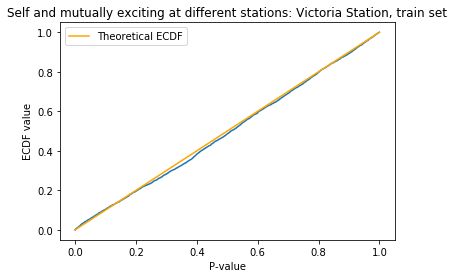

In [194]:
x0,y0 = ecdf(p_values0)
plt.plot(x0,y0)

plt.title("Self and mutually exciting at different stations: Victoria Station, train set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

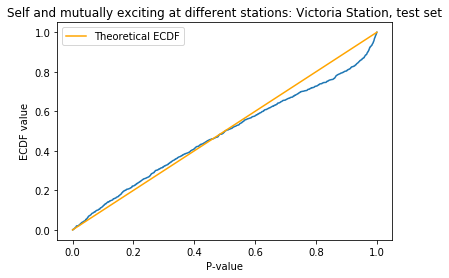

In [60]:
x0,y0 = ecdf(p_values01)
plt.plot(x0,y0)

plt.title("Self and mutually exciting at different stations: Victoria Station, test set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

We could optimise SME (multiple stations) for large k in kappa function, so that the model is reduced to SME (single station).

In [61]:
op_seven_log_likelihood_k = lambda param, location_codes, t, k_dep, k_arr, dist, i: - seven_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]), np.exp(param[2])+np.exp(param[3]), k_dep, k_arr, np.exp(param[4]), dist, i)
mle1 = op.minimize(op_seven_log_likelihood_k, x0 = [-4.5, -10, -2.5, 35, -11], method = 'Nelder-Mead', args=(new_loc, t00, np.exp(50), np.exp(50), new_dist, sid))
mle1

KeyboardInterrupt: 

And the KS statistics.

In [ ]:
beta_dep1, theta_dep1, beta_arr1, theta_arr1 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[2])+np.exp(mle0.x[3])
k_dep1, k_arr1, lambda_b1 = np.exp(50), np.exp(50), np.exp(mle0.x[4])

t_dep = t00['departure'][sid]
compensator_t1 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t1[j+1] = seven_comp(t_dep[j], new_loc, t00, beta1, theta1, lambda_b1, new_dist, k1)

inter_arr_times1 = np.diff(compensator_t1)
p_values1 = np.exp(-inter_arr_times1)

In [ ]:
x1,y1 = ecdf(p_values1)
plt.plot(x1,y1)

plt.title("Self and mutually exciting at different stations with large k: Victoria Station")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Now we fit the SME (single station) model. We get the train and test time for Victoria station only.

In [30]:
t0_dep = train_times['departure'][268]
t0_arr = train_times['arrival'][268]
t0 = {'departure': t0_dep, 'arrival': t0_arr}

t1_dep = test_times['departure'][268]
t1_arr = test_times['arrival'][268]
t1 = {'departure': t1_dep, 'arrival': t1_arr}

And we compute the optimisation.

In [31]:
op_mutual_log_likelihood = lambda param, t: - mutual_log_likelihood(t, np.array([np.exp(param[0]), np.exp(param[1])]), 
                                                                    np.array([np.exp(param[0])+np.exp(param[2]),np.exp(param[1])+np.exp(param[3])]),
                                                                    np.exp(param[4]))

mle2 = op.minimize(op_mutual_log_likelihood, x0 = [-1, -4, -1, -4, 6], method = 'Nelder-Mead', args=(t0,))
mle2

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 14882.636095430296
             x: [-1.986e+00 -4.682e+00 -8.006e-01 -5.373e+00 -6.118e+00]
           nit: 427
          nfev: 684
 final_simplex: (array([[-1.986e+00, -4.682e+00, ..., -5.373e+00,
                        -6.118e+00],
                       [-1.986e+00, -4.682e+00, ..., -5.373e+00,
                        -6.118e+00],
                       ...,
                       [-1.986e+00, -4.682e+00, ..., -5.373e+00,
                        -6.118e+00],
                       [-1.986e+00, -4.682e+00, ..., -5.373e+00,
                        -6.118e+00]]), array([ 1.488e+04,  1.488e+04,  1.488e+04,  1.488e+04,
                        1.488e+04,  1.488e+04]))

We can also set the arrival parameters to be near 0, so that the model is reduced to SE (single station) model.

In [176]:
op_mutual_log_likelihood = lambda param, t: - mutual_log_likelihood(t, np.array([np.exp(param[0]), np.exp(-40)]), 
                                                                    np.array([np.exp(param[0])+np.exp(param[1]),np.exp(-40)]),
                                                                    np.exp(param[2]))

mle2 = op.minimize(op_mutual_log_likelihood, x0 = [1, 1, -4], method = 'Nelder-Mead', args=(t0,))
mle2

 final_simplex: (array([[-4.08649814, -6.28819361, -6.12061286],
       [-4.08650679, -6.28810738, -6.120583  ],
       [-4.08649508, -6.28809681, -6.12058489],
       [-4.08649623, -6.28811794, -6.12056437]]), array([15114.06178122, 15114.06178124, 15114.06178126, 15114.06178127]))
           fun: 15114.061781224662
       message: 'Optimization terminated successfully.'
          nfev: 187
           nit: 101
        status: 0
       success: True
             x: array([-4.08649814, -6.28819361, -6.12061286])

In [175]:
op_mutual_log_likelihood = lambda param, t: - mutual_log_likelihood(t, np.array([np.exp(-40), np.exp(param[0])]), 
                                                                    np.array([np.exp(-40),np.exp(param[0])+np.exp(param[1])]),
                                                                    np.exp(param[2]))

mle2 = op.minimize(op_mutual_log_likelihood, x0 = [1, 1, -4], method = 'Nelder-Mead', args=(t0,))
mle2

 final_simplex: (array([[-4.40972669, -6.23228102, -5.78540025],
       [-4.40972684, -6.23228669, -5.78547687],
       [-4.40970117, -6.23231661, -5.78545979],
       [-4.40970726, -6.23218797, -5.78542492]]), array([15566.76858736, 15566.76858736, 15566.76858745, 15566.76858754]))
           fun: 15566.768587361334
       message: 'Optimization terminated successfully.'
          nfev: 247
           nit: 137
        status: 0
       success: True
             x: array([-4.40972669, -6.23228102, -5.78540025])

And we compute the KS statistics as well as plotting the QQ plots.

In [32]:
beta_dep2, beta_arr2, theta_dep2, theta_arr2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[1]), np.exp(mle2.x[0]) + np.exp(mle2.x[2]), np.exp(mle2.x[1]) + np.exp(mle2.x[3]), np.exp(mle2.x[4])

compensator_t2 = np.zeros(len(t0['departure'])+1)
for i in range(len(t0['departure'])):
    compensator_t2[i+1] = mutual_comp(t0['departure'][i], t0, np.array([beta_dep2, beta_arr2]), np.array([theta_dep2, theta_arr2]), lambda_b2)

inter_arr_times2 = np.diff(compensator_t2)
p_values2 = np.exp(-inter_arr_times2)
ks2 = st.kstest(p_values2, "uniform")
ks_train_mutual.append(ks2.statistic)

In [33]:
ks2

KstestResult(statistic=0.036977663199825817, pvalue=0.0001239636408003523, statistic_location=0.3978607653792767, statistic_sign=-1)

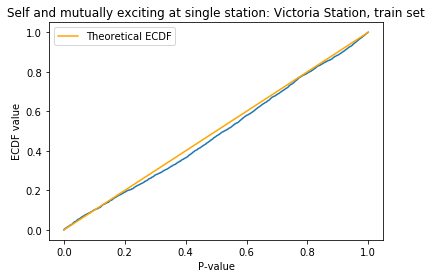

In [180]:
x2,y2 = ecdf(p_values2)
plt.plot(x2,y2)

plt.title("Self and mutually exciting at single station: Victoria Station, train set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

In [181]:
beta_dep2, beta_arr2, theta_dep2, theta_arr2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[1]), np.exp(mle2.x[0]) + np.exp(mle2.x[2]), np.exp(mle2.x[1]) + np.exp(mle2.x[3]), np.exp(mle2.x[4])

compensator_t21 = np.zeros(len(t1['departure'])+1)
for i in range(len(t1['departure'])):
    compensator_t21[i+1] = mutual_comp(t1['departure'][i], t1, np.array([beta_dep2, beta_arr2]), np.array([theta_dep2, theta_arr2]), lambda_b2)

inter_arr_times21 = np.diff(compensator_t21)
p_values21 = np.exp(-inter_arr_times21)
ks21 = st.kstest(p_values21, "uniform")
ks_test_mutual.append(ks21.statistic)

In [182]:
ks21

KstestResult(statistic=0.03876722941703281, pvalue=0.053655792162175815)

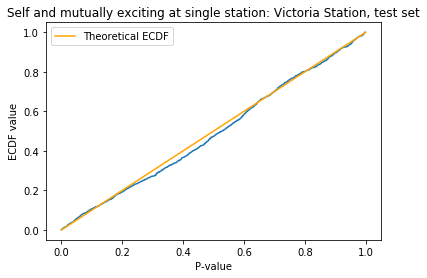

In [183]:
x2,y2 = ecdf(p_values21)
plt.plot(x2,y2)

plt.title("Self and mutually exciting at single station: Victoria Station, test set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

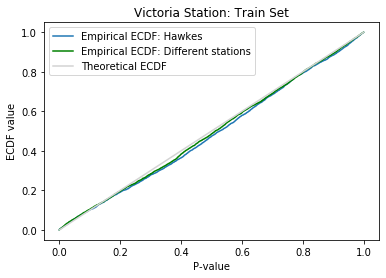

In [195]:
x2,y2 = ecdf(p_values2)
plt.plot(x2,y2,  label="Empirical ECDF: Hawkes")
plt.plot(x0,y0,  label="Empirical ECDF: Different stations", color='green')

plt.title("Victoria Station: Train Set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='lightgray')
plt.legend()
plt.show()

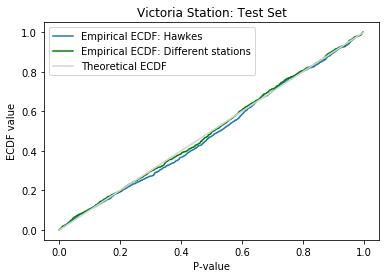

In [196]:
x21,y21 = ecdf(p_values21)
x01,y01 = ecdf(p_values01)
plt.plot(x21,y21,  label="Empirical ECDF: Hawkes")
plt.plot(x01,y01,  label="Empirical ECDF: Different stations", color='green')

plt.title("Victoria Station: Test Set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='lightgray')
plt.legend()
plt.show()

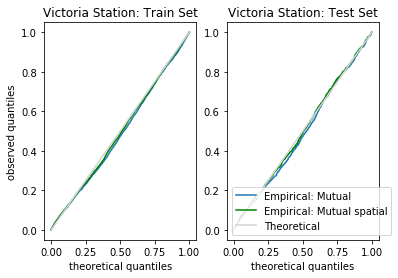

In [197]:
x2,y2 = ecdf(p_values2)
plt.subplot(1, 2, 1)
plt.plot(x2,y2,  label="Empirical ECDF: Mutual")
plt.plot(x0,y0,  label="Empirical ECDF: Mutual spatial", color='green')

plt.title("Victoria Station: Train Set")
plt.xlabel("theoretical quantiles")
plt.ylabel("observed quantiles")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='lightgray')



x21,y21 = ecdf(p_values21)
x01,y01 = ecdf(p_values01)
plt.subplot(1, 2, 2)
plt.plot(x21,y21,  label="Empirical: Mutual")
plt.plot(x01,y01,  label="Empirical: Mutual spatial", color='green')

plt.title("Victoria Station: Test Set")
plt.xlabel("theoretical quantiles")
plt.plot([0,1], [0,1], label="Theoretical", color='lightgray')
plt.legend()

plt.show()


Waterloo Station

The train times at Waterloo Station is

In [22]:
train_times['departure'][374]

array([4.22643617e+01, 4.22849894e+01, 4.56073125e+01, ...,
       1.61052963e+05, 1.61111732e+05, 1.61135115e+05])

We do some preprocessing of time data.

In [23]:
sid = 374
ind = get_station_index(loc_codes, sid)

t0, ind_list, ind1_list = process_times(loc_codes, train_times, sid)
t1, ind_list, ind1_list = process_times(loc_codes, test_times, sid)
    
dist_arr = geo_df[f"{ind}"].to_numpy()

And we choose a threshold of 0.3 miles to select nearby stations.

In [24]:
thres = 0.3
new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
print(len(new_loc));
print(len(new_dist));
print(new_loc)

11
11
[154, 173, 197, 252, 273, 334, 336, 361, 374, 377, 819]


We obtain the time events for the stations in a neighbourhood of 0.3 miles in radius.

In [25]:
t00 = {}
t00_dep = {}
t00_arr = {}
t01 = {}
t01_dep = {}
t01_arr = {}

for loc in new_loc:
    t00_dep[loc] = t0['departure'][loc]
    t00_arr[loc] = t0['arrival'][loc]
    t01_dep[loc] = t1['departure'][loc]
    t01_arr[loc] = t1['arrival'][loc]

t00['departure'] = t00_dep
t00['arrival'] = t00_arr
t01['departure'] = t01_dep
t01['arrival'] = t01_arr

And the optimisation for SME (multiple stations).

In [35]:
op_seven_log_likelihood = lambda param, location_codes, t, dist, i: - seven_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[2])+np.exp(param[3]), np.exp(param[4]), 
                                                                                           np.exp(param[5]), np.exp(param[6]), dist, i)
mle0 = op.minimize(op_seven_log_likelihood, x0 =  [-1, -4, -1, -4, 1, 1, -5],  method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle0

 final_simplex: (array([[-4.13657529, -3.24741613, -6.8618898 , 67.42477137,  2.23659882,
        10.88691151, -7.65222747],
       [-4.13657477, -3.24741441, -6.86189057, 67.42473279,  2.236597  ,
        10.88690602, -7.65221754],
       [-4.13657288, -3.24741282, -6.86188201, 67.42469354,  2.23659776,
        10.88690103, -7.65223418],
       [-4.13657303, -3.24741281, -6.86188974, 67.42474593,  2.23659885,
        10.88690836, -7.65221808],
       [-4.13657391, -3.24741426, -6.86189109, 67.42475002,  2.23659722,
        10.88690892, -7.65221841],
       [-4.13657524, -3.24741397, -6.86188768, 67.42472257,  2.23659548,
        10.88690488, -7.65222984],
       [-4.13657361, -3.24741248, -6.86187967, 67.42468577,  2.23659683,
        10.88690029, -7.65224197],
       [-4.13657355, -3.24741406, -6.86189423, 67.42479196,  2.2366006 ,
        10.88691447, -7.65221118]]), array([23807.39961248, 23807.39961248, 23807.39961248, 23807.39961248,
       23807.39961248, 23807.39961248, 23807.3

We compute the KS statistics for both train and test sets. And the QQ plots.

In [ ]:
beta_dep0, theta_dep0, beta_arr0, theta_arr0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[2])+np.exp(mle0.x[3])
k_dep0, k_arr0, lambda_b0 = np.exp(mle0.x[4]), np.exp(mle0.x[5]), np.exp(mle0.x[6])

t_dep = t00['departure'][sid]
compensator_t0 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t0[j+1] = seven_comp(t_dep[j], new_loc, t00, beta_dep0, theta_dep0, beta_arr0, theta_arr0, k_dep0, k_arr0, lambda_b0, new_dist, sid)

inter_arr_times0 = np.diff(compensator_t0)
p_values0 = np.exp(-inter_arr_times0)
ks0 = st.kstest(p_values0, "uniform")
ks_train_seven.append(ks0.statistic)

In [ ]:
ks0

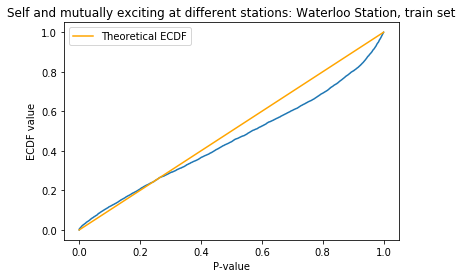

In [225]:
x0,y0 = ecdf(p_values0)
plt.plot(x0,y0)

plt.title("Self and mutually exciting at different stations: Waterloo Station, train set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

In [226]:
beta_dep0, theta_dep0, beta_arr0, theta_arr0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[2])+np.exp(mle0.x[3])
k_dep0, k_arr0, lambda_b0 = np.exp(mle0.x[4]), np.exp(mle0.x[5]), np.exp(mle0.x[6])

t_dep = t01['departure'][sid]
compensator_t01 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t01[j+1] = seven_comp(t_dep[j], new_loc, t01, beta_dep0, theta_dep0, beta_arr0, theta_arr0, k_dep0, k_arr0, lambda_b0, new_dist, sid)

inter_arr_times01 = np.diff(compensator_t01)
p_values01 = np.exp(-inter_arr_times01)
ks1 = st.kstest(p_values01, "uniform")
ks_test_seven.append(ks1.statistic)

In [227]:
ks1

KstestResult(statistic=0.11568889460565324, pvalue=4.072298433338655e-29)

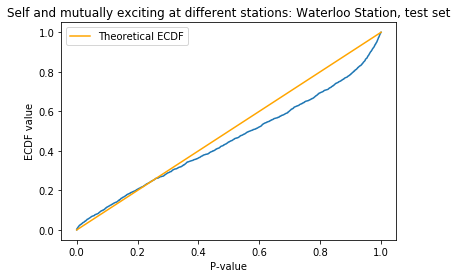

In [228]:
x0,y0 = ecdf(p_values01)
plt.plot(x0,y0)

plt.title("Self and mutually exciting at different stations: Waterloo Station, test set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Seven parameters with large k

In [292]:
op_seven_log_likelihood_k = lambda param, location_codes, t, k_dep, k_arr, dist, i: - seven_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]), np.exp(param[2])+np.exp(param[3]), k_dep, k_arr, np.exp(param[4]), dist, i)
mle1 = op.minimize(op_seven_log_likelihood_k, x0 = [-4.5, -10, -2.5, 35, -11], method = 'Nelder-Mead', args=(new_loc, t00, np.exp(50), np.exp(50), new_dist, sid))
mle1

 final_simplex: (array([[ -4.46000964,  -3.89546493,  -3.62394587,  33.15550335,
        -10.62340343],
       [ -4.46001055,  -3.89546524,  -3.62394716,  33.15546995,
        -10.62340845],
       [ -4.46000957,  -3.89546506,  -3.62395157,  33.1554079 ,
        -10.62341881],
       [ -4.46000817,  -3.89546301,  -3.62394581,  33.1555332 ,
        -10.62339766],
       [ -4.46001061,  -3.89546467,  -3.62394907,  33.15545036,
        -10.6234072 ],
       [ -4.46000756,  -3.89546239,  -3.62394911,  33.15547891,
        -10.62340874]]), array([24148.18059897, 24148.18059897, 24148.18059897, 24148.18059897,
       24148.18059897, 24148.18059897]))
           fun: 24148.18059896906
       message: 'Optimization terminated successfully.'
          nfev: 367
           nit: 215
        status: 0
       success: True
             x: array([ -4.46000964,  -3.89546493,  -3.62394587,  33.15550335,
       -10.62340343])

In [293]:
beta_dep1, theta_dep1, beta_arr1, theta_arr1 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[2])+np.exp(mle0.x[3])
k_dep1, k_arr1, lambda_b1 = np.exp(50), np.exp(50), np.exp(mle0.x[4])

t_dep = t00['departure'][sid]
compensator_t1 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t1[j+1] = seven_comp(t_dep[j], new_loc, t00, beta_dep0, theta_dep0, beta_arr0, theta_arr0, k_dep0, k_arr0, lambda_b0, new_dist, sid)

inter_arr_times1 = np.diff(compensator_t1)
p_values1 = np.exp(-inter_arr_times1)

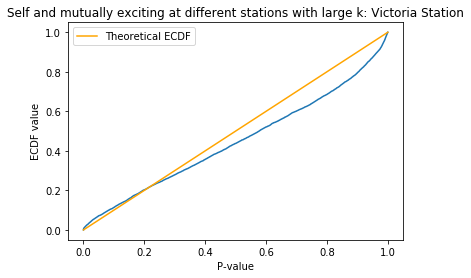

In [294]:
x1,y1 = ecdf(p_values1)
plt.plot(x1,y1)

plt.title("Self and mutually exciting at different stations with large k: Victoria Station")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Now we fit the SME (single station) model. We get the train and test time for Waterloo station only.

In [26]:
t0_dep = train_times['departure'][374]
t0_arr = train_times['arrival'][374]
t0 = {'departure': t0_dep, 'arrival': t0_arr}

t1_dep = test_times['departure'][374]
t1_arr = test_times['arrival'][374]
t1 = {'departure': t1_dep, 'arrival': t1_arr}

And we compute the optimisation.

In [27]:
op_mutual_log_likelihood = lambda param, t: - mutual_log_likelihood(t, np.array([np.exp(param[0]), np.exp(param[1])]), 
                                                                    np.array([np.exp(param[0])+np.exp(param[2]),np.exp(param[1])+np.exp(param[3])]),
                                                                    np.exp(param[4]))

mle2 = op.minimize(op_mutual_log_likelihood, x0 = [-2, -4.5, -1.4, -5, -6], method = 'Nelder-Mead', args=(t0,))
mle2

 final_simplex: (array([[-1.90197501, -4.51678376, -1.41639388, -4.74457649, -5.86350204],
       [-1.90198973, -4.51678231, -1.41641817, -4.74458073, -5.86357314],
       [-1.90201356, -4.51678535, -1.4164261 , -4.74458989, -5.86353404],
       [-1.90204792, -4.51683433, -1.41646307, -4.74460797, -5.86356948],
       [-1.90194883, -4.51674118, -1.41632584, -4.74457199, -5.86355281],
       [-1.90199177, -4.51674719, -1.4163929 , -4.74454537, -5.86352158]]), array([23852.97693362, 23852.97693362, 23852.97693363, 23852.97693395,
       23852.97693397, 23852.976934  ]))
           fun: 23852.976933617287
       message: 'Optimization terminated successfully.'
          nfev: 241
           nit: 141
        status: 0
       success: True
             x: array([-1.90197501, -4.51678376, -1.41639388, -4.74457649, -5.86350204])

And we compute the KS statistics as well as plotting the QQ plots.

In [28]:
beta_dep2, beta_arr2, theta_dep2, theta_arr2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[1]), np.exp(mle2.x[0]) + np.exp(mle2.x[2]), np.exp(mle2.x[1]) + np.exp(mle2.x[3]), np.exp(mle2.x[4])

compensator_t2 = np.zeros(len(t0['departure'])+1)
for i in range(len(t0['departure'])):
    compensator_t2[i+1] = mutual_comp(t0['departure'][i], t0, np.array([beta_dep2, beta_arr2]), np.array([theta_dep2, theta_arr2]), lambda_b2)

inter_arr_times2 = np.diff(compensator_t2)
p_values2 = np.exp(-inter_arr_times2)
ks2 = st.kstest(p_values2, "uniform")
ks_train_mutual.append(ks2.statistic)

In [29]:
ks2

KstestResult(statistic=0.022064954621679456, pvalue=0.001628802999493996)

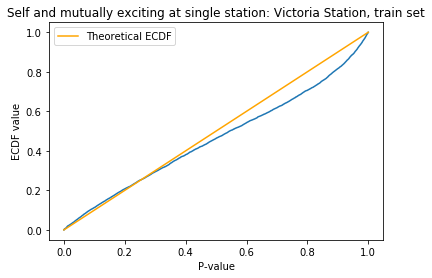

In [213]:
x2,y2 = ecdf(p_values2)
plt.plot(x2,y2)

plt.title("Self and mutually exciting at single station: Victoria Station, train set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

In [133]:
beta_dep2, beta_arr2, theta_dep2, theta_arr2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[1]), np.exp(mle2.x[0]) + np.exp(mle2.x[2]), np.exp(mle2.x[1]) + np.exp(mle2.x[3]), np.exp(mle2.x[4])

compensator_t21 = np.zeros(len(t1['departure'])+1)
for i in range(len(t1['departure'])):
    compensator_t21[i+1] = mutual_comp(t1['departure'][i], t1, np.array([beta_dep2, beta_arr2]), np.array([theta_dep2, theta_arr2]), lambda_b2)

inter_arr_times21 = np.diff(compensator_t21)
p_values21 = np.exp(-inter_arr_times21)
ks21 = st.kstest(p_values21, "uniform")
ks_test_mutual.append(ks21.statistic)

In [134]:
ks21

KstestResult(statistic=0.10381398814434639, pvalue=1.614351198025496e-23)

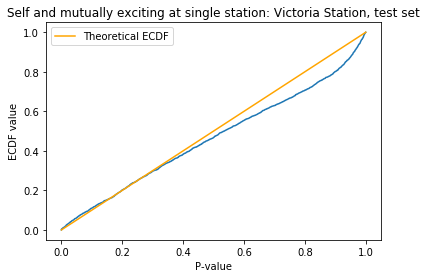

In [135]:
x2,y2 = ecdf(p_values21)
plt.plot(x2,y2)

plt.title("Self and mutually exciting at single station: Victoria Station, test set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Paddington Station

The train times at Paddington Station is

In [92]:
train_times['departure'][186]

array([   405.91724697,    417.19714393,    420.31047521, ...,
       161074.3112733 , 161074.35499577, 161084.4936813 ])

We do some preprocessing of time data.

In [93]:
sid = 186
ind = get_station_index(loc_codes, sid)

t0, ind_list, ind1_list = process_times(loc_codes, train_times, sid)
t1, ind_list, ind1_list = process_times(loc_codes, test_times, sid)
    
dist_arr = geo_df[f"{ind}"].to_numpy()

And we choose a threshold of 0.5 miles to select nearby stations.

In [94]:
thres = 0.5
new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
print(len(new_loc));
print(len(new_dist));
print(new_loc)

7
7
[186, 265, 279, 290, 330, 370, 408]


We obtain the time events for the stations in a neighbourhood of 0.5 miles in radius.

In [95]:
t00 = {}
t00_dep = {}
t00_arr = {}
t01 = {}
t01_dep = {}
t01_arr = {}

for loc in new_loc:
    t00_dep[loc] = t0['departure'][loc]
    t00_arr[loc] = t0['arrival'][loc]
    t01_dep[loc] = t1['departure'][loc]
    t01_arr[loc] = t1['arrival'][loc]

t00['departure'] = t00_dep
t00['arrival'] = t00_arr
t01['departure'] = t01_dep
t01['arrival'] = t01_arr

And the optimisation for SME (multiple stations).

In [107]:
op_seven_log_likelihood = lambda param, location_codes, t, dist, i: - seven_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[2])+np.exp(param[3]), np.exp(param[4]), 
                                                                                           np.exp(param[5]), np.exp(param[6]), dist, i)
mle0 = op.minimize(op_seven_log_likelihood, x0 = [-1, -1, -5, -3,  2, 0.5 , -6],  method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle0

 final_simplex: (array([[-2.38975811, -1.42839893, -4.91671831, -3.64990356,  2.0698317 ,
         0.26670594, -7.1098347 ],
       [-2.38977247, -1.42844274, -4.91674641, -3.64989714,  2.06981255,
         0.26663195, -7.10981841],
       [-2.38975404, -1.42842693, -4.91674383, -3.6499067 ,  2.06983538,
         0.26663591, -7.10984447],
       [-2.38976646, -1.42842727, -4.91671394, -3.64990577,  2.0698336 ,
         0.26670491, -7.10982536],
       [-2.38975067, -1.4283937 , -4.91674663, -3.64991887,  2.06981319,
         0.26665154, -7.10980619],
       [-2.38977222, -1.42844016, -4.91674336, -3.64990396,  2.06979272,
         0.26665393, -7.10986355],
       [-2.38977926, -1.42844658, -4.91676821, -3.6499175 ,  2.06981847,
         0.266607  , -7.10985463],
       [-2.38978123, -1.42847278, -4.91676084, -3.64993706,  2.0698302 ,
         0.26672133, -7.10985704]]), array([20716.40002044, 20716.40002045, 20716.40002045, 20716.40002051,
       20716.40002051, 20716.40002052, 20716.4

We compute the KS statistics for both train and test sets.

In [108]:
beta_dep0, theta_dep0, beta_arr0, theta_arr0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[2])+np.exp(mle0.x[3])
k_dep0, k_arr0, lambda_b0 = np.exp(mle0.x[4]), np.exp(mle0.x[5]), np.exp(mle0.x[6])

t_dep = t00['departure'][sid]
compensator_t0 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t0[j+1] = seven_comp(t_dep[j], new_loc, t00, beta_dep0, theta_dep0, beta_arr0, theta_arr0, k_dep0, k_arr0, lambda_b0, new_dist, sid)

inter_arr_times0 = np.diff(compensator_t0)
p_values0 = np.exp(-inter_arr_times0)
ks0 = st.kstest(p_values0, "uniform")
ks_train_seven.append(ks0.statistic)

In [109]:
ks0

KstestResult(statistic=0.030055346170355324, pvalue=7.499026085824134e-05)

In [110]:
beta_dep0, theta_dep0, beta_arr0, theta_arr0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[2])+np.exp(mle0.x[3])
k_dep0, k_arr0, lambda_b0 = np.exp(mle0.x[4]), np.exp(mle0.x[5]), np.exp(mle0.x[6])

t_dep = t01['departure'][sid]
compensator_t01 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t01[j+1] = seven_comp(t_dep[j], new_loc, t01, beta_dep0, theta_dep0, beta_arr0, theta_arr0, k_dep0, k_arr0, lambda_b0, new_dist, sid)

inter_arr_times01 = np.diff(compensator_t01)
p_values01 = np.exp(-inter_arr_times01)
ks1 = st.kstest(p_values01, "uniform")
ks_test_seven.append(ks1.statistic)

In [111]:
ks1

KstestResult(statistic=0.0257340575257351, pvalue=0.18929973898256092)

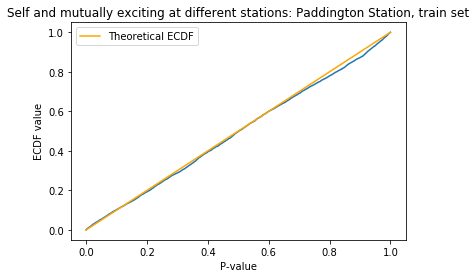

In [112]:
x0,y0 = ecdf(p_values0)
plt.plot(x0,y0)

plt.title("Self and mutually exciting at different stations: Paddington Station, train set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

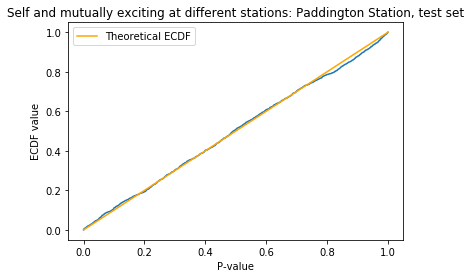

In [239]:
x0,y0 = ecdf(p_values01)
plt.plot(x0,y0)

plt.title("Self and mutually exciting at different stations: Paddington Station, test set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

We could optimise SME (multiple stations) for large k in kappa function, so that the model is reduced to SME (single station).

In [320]:
op_seven_log_likelihood_k = lambda param, location_codes, t, k_dep, k_arr, dist, i: - seven_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]), np.exp(param[2])+np.exp(param[3]), k_dep, k_arr, np.exp(param[4]), dist, i)
mle1 = op.minimize(op_seven_log_likelihood_k, x0 = [-4.5, -10, -2.5, 35, -11], method = 'Nelder-Mead', args=(new_loc, t00, np.exp(50), np.exp(50), new_dist, sid))
mle1

 final_simplex: (array([[-3.983985  , -8.36833288, -3.11880271, 36.37655216, -9.44916914],
       [-3.98398577, -8.36827489, -3.11881318, 36.37653697, -9.44917251],
       [-3.98398532, -8.36838104, -3.11878853, 36.37662534, -9.44917699],
       [-3.98398794, -8.36829129, -3.11880818, 36.37652672, -9.44917931],
       [-3.98398597, -8.36828715, -3.11880951, 36.37655159, -9.44918126],
       [-3.9839838 , -8.36835817, -3.11879737, 36.37658635, -9.44917816]]), array([21467.0443917, 21467.0443917, 21467.0443917, 21467.0443917,
       21467.0443917, 21467.0443917]))
           fun: 21467.044391699408
       message: 'Optimization terminated successfully.'
          nfev: 321
           nit: 185
        status: 0
       success: True
             x: array([-3.983985  , -8.36833288, -3.11880271, 36.37655216, -9.44916914])

And the KS statistics.

In [322]:
beta_dep1, theta_dep1, beta_arr1, theta_arr1 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[2])+np.exp(mle0.x[3])
k_dep1, k_arr1, lambda_b1 = np.exp(50), np.exp(50), np.exp(mle0.x[4])

t_dep = t00['departure'][sid]
compensator_t1 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t1[j+1] = seven_comp(t_dep[j], new_loc, t00, beta_dep0, theta_dep0, beta_arr0, theta_arr0, k_dep0, k_arr0, lambda_b0, new_dist, sid)

inter_arr_times1 = np.diff(compensator_t1)
p_values1 = np.exp(-inter_arr_times1)

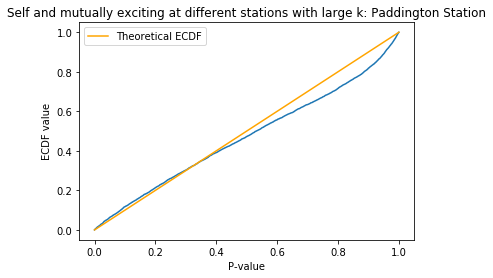

In [323]:
x1,y1 = ecdf(p_values1)
plt.plot(x1,y1)

plt.title("Self and mutually exciting at different stations with large k: Paddington Station")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Now we fit the SME (single station) model. We get the train and test time for Paddington station only.

In [51]:
t0_dep = train_times['departure'][186]
t0_arr = train_times['arrival'][186]
t0 = {'departure': t0_dep, 'arrival': t0_arr}

t1_dep = test_times['departure'][186]
t1_arr = test_times['arrival'][186]
t1 = {'departure': t1_dep, 'arrival': t1_arr}

And we compute the optimisation.

In [63]:
op_mutual_log_likelihood = lambda param, t: - mutual_log_likelihood(t, np.array([np.exp(param[0]), np.exp(param[1])]), 
                                                                    np.array([np.exp(param[0])+np.exp(param[2]),np.exp(param[1])+np.exp(param[3])]),
                                                                    np.exp(param[4]))

mle2 = op.minimize(op_mutual_log_likelihood, x0 = [2, 2, -1, -1, -1], method = 'Nelder-Mead', args=(t0,))
mle2

 final_simplex: (array([[-2.50212293, -4.57224926, -1.86113008, -4.94904226, -6.12132067],
       [-2.50211983, -4.57223813, -1.86111133, -4.9490021 , -6.12132818],
       [-2.50212608, -4.57223353, -1.86107424, -4.94901988, -6.12132485],
       [-2.50214502, -4.5722428 , -1.86115209, -4.94902783, -6.12123688],
       [-2.50220851, -4.57221981, -1.86122464, -4.94897888, -6.12126363],
       [-2.5020918 , -4.5722108 , -1.86110893, -4.94902333, -6.12131192]]), array([21040.18007225, 21040.18007235, 21040.18007245, 21040.18007268,
       21040.18007278, 21040.1800728 ]))
           fun: 21040.180072254825
       message: 'Optimization terminated successfully.'
          nfev: 565
           nit: 354
        status: 0
       success: True
             x: array([-2.50212293, -4.57224926, -1.86113008, -4.94904226, -6.12132067])

And we compute the KS statistics as well as plotting the QQ plots.

In [64]:
beta_dep2, beta_arr2, theta_dep2, theta_arr2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[1]), np.exp(mle2.x[0]) + np.exp(mle2.x[2]), np.exp(mle2.x[1]) + np.exp(mle2.x[3]), np.exp(mle2.x[4])

compensator_t2 = np.zeros(len(t0['departure'])+1)
for i in range(len(t0['departure'])):
    compensator_t2[i+1] = mutual_comp(t0['departure'][i], t0, np.array([beta_dep2, beta_arr2]), np.array([theta_dep2, theta_arr2]), lambda_b2)

inter_arr_times2 = np.diff(compensator_t2)
p_values2 = np.exp(-inter_arr_times2)
ks2 = st.kstest(p_values2, "uniform")
ks_train_mutual.append(ks2.statistic)

In [65]:
ks2

KstestResult(statistic=0.035484874687698564, pvalue=1.3534141032840045e-06)

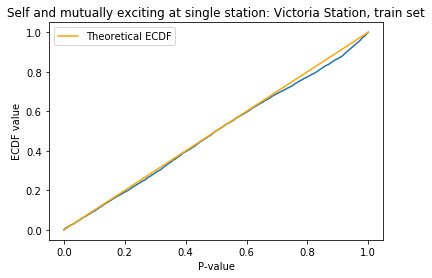

In [66]:
x2,y2 = ecdf(p_values2)
plt.plot(x2,y2)

plt.title("Self and mutually exciting at single station: Victoria Station, train set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

In [67]:
beta_dep2, beta_arr2, theta_dep2, theta_arr2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[1]), np.exp(mle2.x[0]) + np.exp(mle2.x[2]), np.exp(mle2.x[1]) + np.exp(mle2.x[3]), np.exp(mle2.x[4])

compensator_t21 = np.zeros(len(t1['departure'])+1)
for i in range(len(t1['departure'])):
    compensator_t21[i+1] = mutual_comp(t1['departure'][i], t1, np.array([beta_dep2, beta_arr2]), np.array([theta_dep2, theta_arr2]), lambda_b2)

inter_arr_times21 = np.diff(compensator_t21)
p_values21 = np.exp(-inter_arr_times21)
ks21 = st.kstest(p_values21, "uniform")
ks_test_mutual.append(ks21.statistic)

In [68]:
ks21

KstestResult(statistic=0.03567824545477838, pvalue=0.021711490284247997)

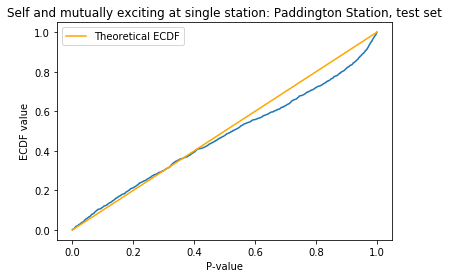

In [148]:
x2,y2 = ecdf(p_values21)
plt.plot(x2,y2)

plt.title("Self and mutually exciting at single station: Paddington Station, test set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

London Bridge

The train times at London Bridge station is

In [71]:
train_times['departure'][706]

array([1.37626145e+02, 3.97853362e+02, 4.01353512e+02, ...,
       1.61163756e+05, 1.61164990e+05, 1.61219080e+05])

We do some preprocessing of time data.

In [72]:
sid = 706
ind = get_station_index(loc_codes, sid)

t0, ind_list, ind1_list = process_times(loc_codes, train_times, sid)
t1, ind_list, ind1_list = process_times(loc_codes, test_times, sid)
    
dist_arr = geo_df[f"{ind}"].to_numpy()

And we choose a threshold of 0.4 miles to select nearby stations.

In [73]:
thres = 0.4
new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
print(len(new_loc));
print(len(new_dist));
print(new_loc)

5
5
[85, 278, 308, 314, 706]


We obtain the time events for the stations in a neighbourhood of 0.4 miles in radius.

In [74]:
t00 = {}
t00_dep = {}
t00_arr = {}
t01 = {}
t01_dep = {}
t01_arr = {}

for loc in new_loc:
    t00_dep[loc] = t0['departure'][loc]
    t00_arr[loc] = t0['arrival'][loc]
    t01_dep[loc] = t1['departure'][loc]
    t01_arr[loc] = t1['arrival'][loc]

t00['departure'] = t00_dep
t00['arrival'] = t00_arr
t01['departure'] = t01_dep
t01['arrival'] = t01_arr

And the optimisation for SME (multiple stations).

In [84]:
op_seven_log_likelihood = lambda param, location_codes, t, dist, i: - seven_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[2])+np.exp(param[3]), np.exp(param[4]), 
                                                                                           np.exp(param[5]), np.exp(param[6]), dist, i)
mle0 = op.minimize(op_seven_log_likelihood, x0 =[ -1,  -0.5, -5,  -4, 2, 2, -6],  method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle0

 final_simplex: (array([[-1.69673831, -0.43306718, -5.46592757, -3.81247675,  2.41229918,
         0.2366885 , -9.60020616],
       [-1.69674274, -0.43307045, -5.46594055, -3.81247825,  2.41229427,
         0.23665472, -9.60024365],
       [-1.69673794, -0.43306897, -5.46592733, -3.81247597,  2.41229373,
         0.23669179, -9.60013494],
       [-1.69673552, -0.43306072, -5.46593012, -3.81248019,  2.41229726,
         0.23668771, -9.60016954],
       [-1.69673984, -0.43306972, -5.46593013, -3.81248148,  2.41229141,
         0.23669563, -9.60027965],
       [-1.69673617, -0.43306827, -5.46592987, -3.81247316,  2.41229786,
         0.23667073, -9.60021043],
       [-1.69674199, -0.43306838, -5.46592719, -3.81247251,  2.41229103,
         0.23667978, -9.60014392],
       [-1.69673783, -0.43306957, -5.46593   , -3.81247389,  2.41229452,
         0.23668221, -9.60017857]]), array([17353.17204276, 17353.17204277, 17353.17204277, 17353.17204277,
       17353.17204277, 17353.17204277, 17353.1

We compute the KS statistics for both train and test sets.

In [85]:
beta_dep0, theta_dep0, beta_arr0, theta_arr0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[2])+np.exp(mle0.x[3])
k_dep0, k_arr0, lambda_b0 = np.exp(mle0.x[4]), np.exp(mle0.x[5]), np.exp(mle0.x[6])

t_dep = t00['departure'][sid]
compensator_t0 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t0[j+1] = seven_comp(t_dep[j], new_loc, t00, beta_dep0, theta_dep0, beta_arr0, theta_arr0, k_dep0, k_arr0, lambda_b0, new_dist, sid)

inter_arr_times0 = np.diff(compensator_t0)
p_values0 = np.exp(-inter_arr_times0)
ks0 = st.kstest(p_values0, "uniform")
ks_train_seven.append(ks0.statistic)

In [86]:
ks0

KstestResult(statistic=0.02367265599953494, pvalue=0.012103146620508017)

In [87]:
beta_dep0, theta_dep0, beta_arr0, theta_arr0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[2])+np.exp(mle0.x[3])
k_dep0, k_arr0, lambda_b0 = np.exp(mle0.x[4]), np.exp(mle0.x[5]), np.exp(mle0.x[6])

t_dep = t01['departure'][sid]
compensator_t01 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t01[j+1] = seven_comp(t_dep[j], new_loc, t01, beta_dep0, theta_dep0, beta_arr0, theta_arr0, k_dep0, k_arr0, lambda_b0, new_dist, sid)

inter_arr_times01 = np.diff(compensator_t01)
p_values01 = np.exp(-inter_arr_times01)
ks1 = st.kstest(p_values01, "uniform")
ks_test_seven.append(ks1.statistic)

In [88]:
ks1

KstestResult(statistic=0.021959098335402327, pvalue=0.4803195842059322)

And the QQ plots.

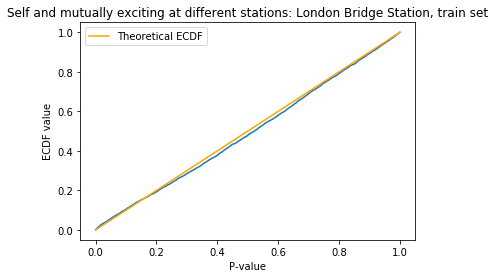

In [89]:
x0,y0 = ecdf(p_values0)
plt.plot(x0,y0)

plt.title("Self and mutually exciting at different stations: London Bridge Station, train set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

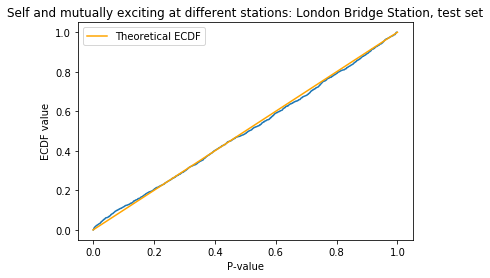

In [90]:
x0,y0 = ecdf(p_values01)
plt.plot(x0,y0)

plt.title("Self and mutually exciting at different stations: London Bridge Station, test set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

We could optimise SME (multiple stations) for large k in kappa function, so that the model is reduced to SME (single station).

In [344]:
op_seven_log_likelihood_k = lambda param, location_codes, t, k_dep, k_arr, dist, i: - seven_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]), np.exp(param[2])+np.exp(param[3]), k_dep, k_arr, np.exp(param[4]), dist, i)
mle1 = op.minimize(op_seven_log_likelihood_k, x0 = [-4.5, -10, -2.5, 35, -11], method = 'Nelder-Mead', args=(new_loc, t00, np.exp(50), np.exp(50), new_dist, sid))
mle1

 final_simplex: (array([[ -4.44202952, -10.74997219,  -2.53719993,  32.2433819 ,
        -11.24377637],
       [ -4.44202952, -10.75001317,  -2.53719749,  32.243287  ,
        -11.24377688],
       [ -4.44202941, -10.75000964,  -2.53719708,  32.24331244,
        -11.24377573],
       [ -4.44202945, -10.75001162,  -2.53719591,  32.24332085,
        -11.24377706],
       [ -4.44202955, -10.74998048,  -2.53720053,  32.24333215,
        -11.24377429],
       [ -4.4420296 , -10.74997069,  -2.53719953,  32.24342499,
        -11.24377334]]), array([18374.45654724, 18374.45654724, 18374.45654724, 18374.45654724,
       18374.45654724, 18374.45654724]))
           fun: 18374.4565472393
       message: 'Optimization terminated successfully.'
          nfev: 224
           nit: 121
        status: 0
       success: True
             x: array([ -4.44202952, -10.74997219,  -2.53719993,  32.2433819 ,
       -11.24377637])

And the KS statistics.

In [345]:
beta_dep1, theta_dep1, beta_arr1, theta_arr1 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[2])+np.exp(mle0.x[3])
k_dep1, k_arr1, lambda_b1 = np.exp(50), np.exp(50), np.exp(mle0.x[4])

t_dep = t00['departure'][sid]
compensator_t1 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t1[j+1] = seven_comp(t_dep[j], new_loc, t00, beta_dep0, theta_dep0, beta_arr0, theta_arr0, k_dep0, k_arr0, lambda_b0, new_dist, sid)

inter_arr_times1 = np.diff(compensator_t1)
p_values1 = np.exp(-inter_arr_times1)

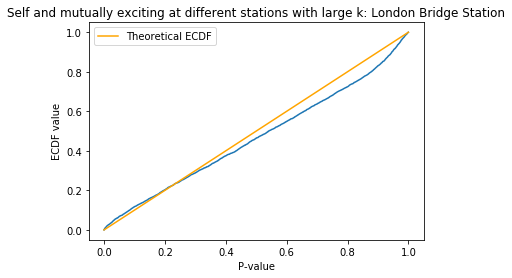

In [346]:
x1,y1 = ecdf(p_values1)
plt.plot(x1,y1)

plt.title("Self and mutually exciting at different stations with large k: London Bridge Station")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Now we fit the SME (single station) model. We get the train and test time for London Bridge Station only.

In [149]:
t0_dep = train_times['departure'][374]
t0_arr = train_times['arrival'][374]
t0 = {'departure': t0_dep, 'arrival': t0_arr}

t1_dep = test_times['departure'][374]
t1_arr = test_times['arrival'][374]
t1 = {'departure': t1_dep, 'arrival': t1_arr}

And we compute the optimisation.

In [150]:
op_mutual_log_likelihood = lambda param, t: - mutual_log_likelihood(t, np.array([np.exp(param[0]), np.exp(param[1])]), 
                                                                    np.array([np.exp(param[0])+np.exp(param[2]),np.exp(param[1])+np.exp(param[3])]),
                                                                    np.exp(param[4]))

mle2 = op.minimize(op_mutual_log_likelihood, x0 = [0.1, 0.1, 0.1, 0.1, 0.1], method = 'Nelder-Mead', args=(t0,))
mle2

 final_simplex: (array([[-3.41663091, -6.72636442, -5.82086826, 16.0955579 , -5.58206467],
       [-3.41663344, -6.72635072, -5.82085234, 16.09552168, -5.58205114],
       [-3.41664041, -6.7263716 , -5.82087465, 16.09557115, -5.58206273],
       [-3.41663141, -6.72637611, -5.82089035, 16.09558643, -5.58205479],
       [-3.41662844, -6.72637151, -5.82087803, 16.09557739, -5.58207046],
       [-3.41663898, -6.72639633, -5.820907  , 16.09563529, -5.58207673]]), array([24293.81224705, 24293.81224705, 24293.81224706, 24293.81224706,
       24293.81224706, 24293.81224707]))
           fun: 24293.81224704551
       message: 'Optimization terminated successfully.'
          nfev: 473
           nit: 285
        status: 0
       success: True
             x: array([-3.41663091, -6.72636442, -5.82086826, 16.0955579 , -5.58206467])

And we compute the KS statistics as well as plotting the QQ plots.

In [151]:
beta_dep2, beta_arr2, theta_dep2, theta_arr2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[1]), np.exp(mle2.x[0]) + np.exp(mle2.x[2]), np.exp(mle2.x[1]) + np.exp(mle2.x[3]), np.exp(mle2.x[4])

compensator_t2 = np.zeros(len(t0['departure'])+1)
for i in range(len(t0['departure'])):
    compensator_t2[i+1] = mutual_comp(t0['departure'][i], t0, np.array([beta_dep2, beta_arr2]), np.array([theta_dep2, theta_arr2]), lambda_b2)

inter_arr_times2 = np.diff(compensator_t2)
p_values2 = np.exp(-inter_arr_times2)
ks2 = st.kstest(p_values2, "uniform")
ks_train_mutual.append(ks2.statistic)

In [152]:
ks2

KstestResult(statistic=0.0977377756447404, pvalue=4.8855820105630465e-61)

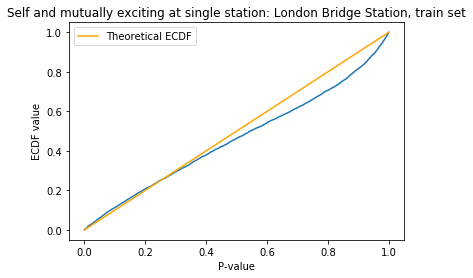

In [153]:
x2,y2 = ecdf(p_values2)
plt.plot(x2,y2)

plt.title("Self and mutually exciting at single station: London Bridge Station, train set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

In [154]:
beta_dep2, beta_arr2, theta_dep2, theta_arr2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[1]), np.exp(mle2.x[0]) + np.exp(mle2.x[2]), np.exp(mle2.x[1]) + np.exp(mle2.x[3]), np.exp(mle2.x[4])

compensator_t21 = np.zeros(len(t1['departure'])+1)
for i in range(len(t1['departure'])):
    compensator_t21[i+1] = mutual_comp(t1['departure'][i], t1, np.array([beta_dep2, beta_arr2]), np.array([theta_dep2, theta_arr2]), lambda_b2)

inter_arr_times21 = np.diff(compensator_t21)
p_values21 = np.exp(-inter_arr_times21)
ks21 = st.kstest(p_values21, "uniform")
ks_test_mutual.append(ks21.statistic)

In [155]:
ks21

KstestResult(statistic=0.10381398814434639, pvalue=1.614351198025496e-23)

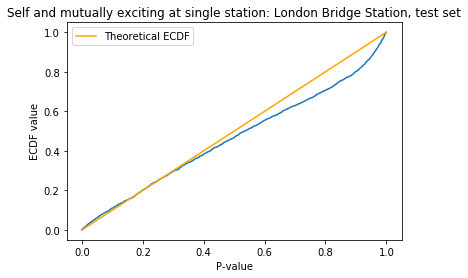

In [156]:
x2,y2 = ecdf(p_values21)
plt.plot(x2,y2)

plt.title("Self and mutually exciting at single station: London Bridge Station, test set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

King's Cross

The train times at King's Cross station is

In [157]:
train_times['departure'][798]

array([   375.51087771,    418.0031134 ,    420.46245786, ...,
       161153.91503428, 161219.47165701, 161219.76871898])

We do some preprocessing of time data.

In [356]:
sid = 798
ind = get_station_index(loc_codes, sid)

t0, ind_list, ind1_list = process_times(loc_codes, train_times, sid)
t1, ind_list, ind1_list = process_times(loc_codes, test_times, sid)
    
dist_arr = geo_df[f"{ind}"].to_numpy()

And we choose a threshold of 0.4 miles to select nearby stations.

In [357]:
thres = 0.4
new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
print(len(new_loc));
print(len(new_dist));
print(new_loc)

6
6
[4, 14, 70, 593, 793, 798]


We obtain the time events for the stations in a neighbourhood of 0.4 miles in radius.

In [358]:
t00 = {}
t00_dep = {}
t00_arr = {}
t01 = {}
t01_dep = {}
t01_arr = {}

for loc in new_loc:
    t00_dep[loc] = t0['departure'][loc]
    t00_arr[loc] = t0['arrival'][loc]
    t01_dep[loc] = t1['departure'][loc]
    t01_arr[loc] = t1['arrival'][loc]

t00['departure'] = t00_dep
t00['arrival'] = t00_arr
t01['departure'] = t01_dep
t01['arrival'] = t01_arr

And the optimisation for SME (multiple stations).

In [359]:
op_seven_log_likelihood = lambda param, location_codes, t, dist, i: - seven_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[2])+np.exp(param[3]), np.exp(param[4]), 
                                                                                           np.exp(param[5]), np.exp(param[6]), dist, i)
mle0 = op.minimize(op_seven_log_likelihood, x0 =[ -4,  -3,  -5,   1, 1,  -1, -2],  method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle0

 final_simplex: (array([[ -5.60242525,  -4.06500484,   1.15841218,   9.35276965,
        -21.72739753,  33.55546805, -12.68926239],
       [ -5.60242452,  -4.06500426,   1.15840135,   9.35275844,
        -21.72736696,  33.55540783, -12.68926398],
       [ -5.60242368,  -4.06500319,   1.15840755,   9.35276828,
        -21.72739452,  33.55545786, -12.68926939],
       [ -5.60242478,  -4.06500405,   1.15838288,   9.35275636,
        -21.72736785,  33.55541532, -12.68925006],
       [ -5.60242388,  -4.06500304,   1.15842192,   9.35276832,
        -21.72739104,  33.55545187, -12.68927438],
       [ -5.60242481,  -4.06500387,   1.15843224,   9.35276231,
        -21.72737187,  33.55542829, -12.68926157],
       [ -5.60242346,  -4.065003  ,   1.1584427 ,   9.35277858,
        -21.72741928,  33.55553653, -12.68924083],
       [ -5.60242543,  -4.0650047 ,   1.15844678,   9.35278541,
        -21.72743367,  33.55552721, -12.68928549]]), array([15278.32726477, 15278.32726477, 15278.32726477, 15278.

We compute the KS statistics for both train and test sets.

In [360]:
beta_dep0, theta_dep0, beta_arr0, theta_arr0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[2])+np.exp(mle0.x[3])
k_dep0, k_arr0, lambda_b0 = np.exp(mle0.x[4]), np.exp(mle0.x[5]), np.exp(mle0.x[6])

t_dep = t00['departure'][sid]
compensator_t0 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t0[j+1] = seven_comp(t_dep[j], new_loc, t00, beta_dep0, theta_dep0, beta_arr0, theta_arr0, k_dep0, k_arr0, lambda_b0, new_dist, sid)

inter_arr_times0 = np.diff(compensator_t0)
p_values0 = np.exp(-inter_arr_times0)
ks0 = st.kstest(p_values0, "uniform")
ks_train_seven.append(ks0.statistic)

In [361]:
ks0

KstestResult(statistic=0.17917887541712008, pvalue=1.4918064829172407e-97)

In [362]:
beta_dep0, theta_dep0, beta_arr0, theta_arr0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[2])+np.exp(mle0.x[3])
k_dep0, k_arr0, lambda_b0 = np.exp(mle0.x[4]), np.exp(mle0.x[5]), np.exp(mle0.x[6])

t_dep = t01['departure'][sid]
compensator_t01 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t01[j+1] = seven_comp(t_dep[j], new_loc, t01, beta_dep0, theta_dep0, beta_arr0, theta_arr0, k_dep0, k_arr0, lambda_b0, new_dist, sid)

inter_arr_times01 = np.diff(compensator_t01)
p_values01 = np.exp(-inter_arr_times01)
ks1 = st.kstest(p_values01, "uniform")
ks_test_seven.append(ks1.statistic)

In [363]:
ks1

KstestResult(statistic=0.20607487936760915, pvalue=2.689335098772465e-48)

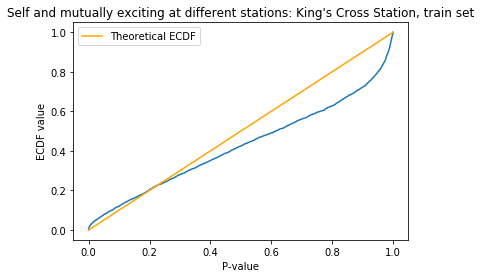

In [364]:
x0,y0 = ecdf(p_values0)
plt.plot(x0,y0)

plt.title("Self and mutually exciting at different stations: King's Cross Station, train set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

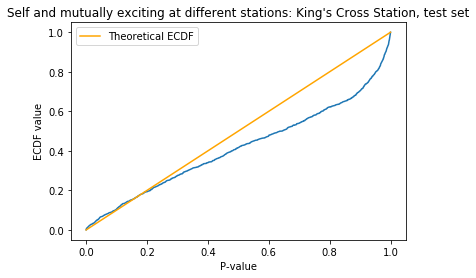

In [365]:
x0,y0 = ecdf(p_values01)
plt.plot(x0,y0)

plt.title("Self and mutually exciting at different stations: King's Cross Station, test set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

We could optimise SME (multiple stations) for large k in kappa function, so that the model is reduced to SME (single station).

In [366]:
op_seven_log_likelihood_k = lambda param, location_codes, t, k_dep, k_arr, dist, i: - seven_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]), np.exp(param[2])+np.exp(param[3]), k_dep, k_arr, np.exp(param[4]), dist, i)
mle1 = op.minimize(op_seven_log_likelihood_k, x0 = [-4.5, -10, -2.5, 35, -11], method = 'Nelder-Mead', args=(new_loc, t00, np.exp(50), np.exp(50), new_dist, sid))
mle1

 final_simplex: (array([[ -4.6383539 , -12.22991866,  -0.64829932,  63.94989235,
        -12.03034277],
       [ -4.63835389, -12.2299226 ,  -0.64829554,  63.94995709,
        -12.03034276],
       [ -4.63835389, -12.22992211,  -0.64829628,  63.94994859,
        -12.03034275],
       [ -4.6383539 , -12.2299219 ,  -0.64829587,  63.94994683,
        -12.03034276],
       [ -4.6383539 , -12.22991796,  -0.6482988 ,  63.94988297,
        -12.0303428 ],
       [ -4.63835389, -12.22992125,  -0.64829666,  63.94993503,
        -12.03034275]]), array([15349.10200831, 15349.10200831, 15349.10200831, 15349.10200831,
       15349.10200831, 15349.10200831]))
           fun: 15349.102008306332
       message: 'Optimization terminated successfully.'
          nfev: 341
           nit: 181
        status: 0
       success: True
             x: array([ -4.6383539 , -12.22991866,  -0.64829932,  63.94989235,
       -12.03034277])

In [367]:
beta_dep1, theta_dep1, beta_arr1, theta_arr1 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[2])+np.exp(mle0.x[3])
k_dep1, k_arr1, lambda_b1 = np.exp(50), np.exp(50), np.exp(mle0.x[4])

t_dep = t00['departure'][sid]
compensator_t1 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t1[j+1] = seven_comp(t_dep[j], new_loc, t00, beta_dep0, theta_dep0, beta_arr0, theta_arr0, k_dep0, k_arr0, lambda_b0, new_dist, sid)

inter_arr_times1 = np.diff(compensator_t1)
p_values1 = np.exp(-inter_arr_times1)

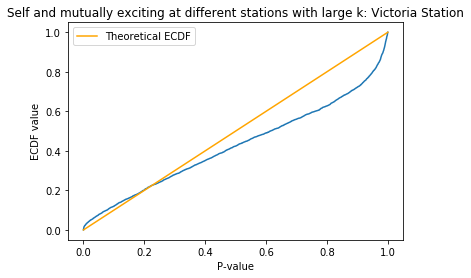

In [368]:
x1,y1 = ecdf(p_values1)
plt.plot(x1,y1)

plt.title("Self and mutually exciting at different stations with large k: Victoria Station")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Now we fit the SME (single station) model. We get the train and test time for King's Cross station only.

In [369]:
t0_dep = train_times['departure'][798]
t0_arr = train_times['arrival'][798]
t0 = {'departure': t0_dep, 'arrival': t0_arr}

t1_dep = test_times['departure'][798]
t1_arr = test_times['arrival'][798]
t1 = {'departure': t1_dep, 'arrival': t1_arr}

And we compute the optimisation.

In [370]:
op_mutual_log_likelihood = lambda param, t: - mutual_log_likelihood(t, np.array([np.exp(param[0]), np.exp(param[1])]), 
                                                                    np.array([np.exp(param[0])+np.exp(param[2]),np.exp(param[1])+np.exp(param[3])]),
                                                                    np.exp(param[4]))

mle2 = op.minimize(op_mutual_log_likelihood, x0 = [0.1, 0.1, 0.1, 0.1, 0.1], method = 'Nelder-Mead', args=(t0,))
mle2

 final_simplex: (array([[ -4.63819202,  -2.99198912, -12.61203363,  30.32941381,
        -12.03027385],
       [ -4.63819436,  -2.99198698, -12.61210356,  30.32949436,
        -12.0302944 ],
       [ -4.63819661,  -2.99198866, -12.61209188,  30.32948545,
        -12.03029103],
       [ -4.63819344,  -2.99198868, -12.61204254,  30.32942155,
        -12.03027198],
       [ -4.63819774,  -2.99199545, -12.61194279,  30.32931935,
        -12.03024235],
       [ -4.6381926 ,  -2.99198883, -12.61202635,  30.3294011 ,
        -12.03026586]]), array([15349.10205296, 15349.10205296, 15349.10205296, 15349.10205296,
       15349.10205297, 15349.10205297]))
           fun: 15349.102052964023
       message: 'Optimization terminated successfully.'
          nfev: 553
           nit: 334
        status: 0
       success: True
             x: array([ -4.63819202,  -2.99198912, -12.61203363,  30.32941381,
       -12.03027385])

And we compute the KS statistics as well as plotting the QQ plots.

In [371]:
beta_dep2, beta_arr2, theta_dep2, theta_arr2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[1]), np.exp(mle2.x[0]) + np.exp(mle2.x[2]), np.exp(mle2.x[1]) + np.exp(mle2.x[3]), np.exp(mle2.x[4])

compensator_t2 = np.zeros(len(t0['departure'])+1)
for i in range(len(t0['departure'])):
    compensator_t2[i+1] = mutual_comp(t0['departure'][i], t0, np.array([beta_dep2, beta_arr2]), np.array([theta_dep2, theta_arr2]), lambda_b2)

inter_arr_times2 = np.diff(compensator_t2)
p_values2 = np.exp(-inter_arr_times2)
ks2 = st.kstest(p_values2, "uniform")
ks_train_mutual.append(ks2.statistic)

In [372]:
ks2

KstestResult(statistic=0.16344531184769218, pvalue=3.035082287402514e-81)

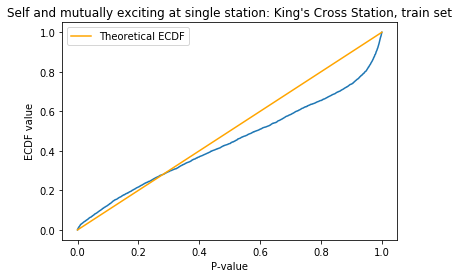

In [373]:
x2,y2 = ecdf(p_values2)
plt.plot(x2,y2)

plt.title("Self and mutually exciting at single station: King's Cross Station, train set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

In [374]:
beta_dep2, beta_arr2, theta_dep2, theta_arr2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[1]), np.exp(mle2.x[0]) + np.exp(mle2.x[2]), np.exp(mle2.x[1]) + np.exp(mle2.x[3]), np.exp(mle2.x[4])

compensator_t21 = np.zeros(len(t1['departure'])+1)
for i in range(len(t1['departure'])):
    compensator_t21[i+1] = mutual_comp(t1['departure'][i], t1, np.array([beta_dep2, beta_arr2]), np.array([theta_dep2, theta_arr2]), lambda_b2)

inter_arr_times21 = np.diff(compensator_t21)
p_values21 = np.exp(-inter_arr_times21)
ks21 = st.kstest(p_values21, "uniform")
ks_test_mutual.append(ks21.statistic)

In [375]:
ks21

KstestResult(statistic=0.1808868766863133, pvalue=3.11055275309145e-37)

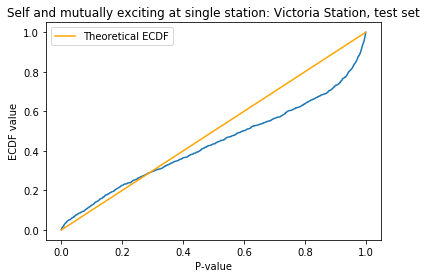

In [376]:
x2,y2 = ecdf(p_values21)
plt.plot(x2,y2)

plt.title("Self and mutually exciting at single station: King's Cross Station, test set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Marylebone

The train times at Marylebone station is

In [377]:
train_times['departure'][45]

array([788074.57708321, 788100.05941808, 788113.77020812, ...,
       948759.94843687, 948909.28615836, 948913.29515947])

We do some preprocessing of time data.

In [378]:
sid = 45
ind = get_station_index(loc_codes, sid)

t0, ind_list, ind1_list = process_times(loc_codes, train_times, sid)
t1, ind_list, ind1_list = process_times(loc_codes, test_times, sid)
    
dist_arr = geo_df[f"{ind}"].to_numpy()

And we choose a threshold of 0.4 miles to select nearby stations.

In [379]:
thres = 0.4
new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
print(len(new_loc));
print(len(new_dist));
print(new_loc)

7
7
[45, 114, 182, 201, 605, 759, 760]


We obtain the time events for the stations in a neighbourhood of 0.4 miles in radius.

In [380]:
t00 = {}
t00_dep = {}
t00_arr = {}
t01 = {}
t01_dep = {}
t01_arr = {}

for loc in new_loc:
    t00_dep[loc] = t0['departure'][loc]
    t00_arr[loc] = t0['arrival'][loc]
    t01_dep[loc] = t1['departure'][loc]
    t01_arr[loc] = t1['arrival'][loc]

t00['departure'] = t00_dep
t00['arrival'] = t00_arr
t01['departure'] = t01_dep
t01['arrival'] = t01_arr

And the optimisation for SME (multiple stations).

In [381]:
op_seven_log_likelihood = lambda param, location_codes, t, dist, i: - seven_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[2])+np.exp(param[3]), np.exp(param[4]), 
                                                                                           np.exp(param[5]), np.exp(param[6]), dist, i)
mle0 = op.minimize(op_seven_log_likelihood, x0 =[ -4.14543286,  -3.52035141,  -6.00164515,   1.80372439, 1.58596656,  -0.81565948, -21.48335099],  method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle0

 final_simplex: (array([[ -3.84893166,  -4.12285116, -32.14976326,   0.36139456,
          2.23375904,   0.83134336, -10.32665195],
       [ -3.84893166,  -4.12285116, -32.14972481,   0.3613965 ,
          2.23375904,   0.83134096, -10.32665195],
       [ -3.84893166,  -4.12285116, -32.14972383,   0.36139655,
          2.23375904,   0.8313409 , -10.32665195],
       [ -3.84893166,  -4.12285116, -32.14983469,   0.36139094,
          2.23375904,   0.83134782, -10.32665195],
       [ -3.84893166,  -4.12285116, -32.14980269,   0.36139256,
          2.23375904,   0.83134582, -10.32665195],
       [ -3.84893166,  -4.12285116, -32.14975564,   0.36139494,
          2.23375904,   0.83134288, -10.32665195],
       [ -3.84893166,  -4.12285116, -32.14980682,   0.36139235,
          2.23375904,   0.83134608, -10.32665195],
       [ -3.84893166,  -4.12285116, -32.14980692,   0.36139235,
          2.23375904,   0.83134608, -10.32665195]]), array([15704.03476588, 15704.03476588, 15704.03476588, 15704.

We compute the KS statistics for both train and test sets.

In [382]:
beta_dep0, theta_dep0, beta_arr0, theta_arr0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[2])+np.exp(mle0.x[3])
k_dep0, k_arr0, lambda_b0 = np.exp(mle0.x[4]), np.exp(mle0.x[5]), np.exp(mle0.x[6])

t_dep = t00['departure'][sid]
compensator_t0 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t0[j+1] = seven_comp(t_dep[j], new_loc, t00, beta_dep0, theta_dep0, beta_arr0, theta_arr0, k_dep0, k_arr0, lambda_b0, new_dist, sid)

inter_arr_times0 = np.diff(compensator_t0)
p_values0 = np.exp(-inter_arr_times0)
ks0 = st.kstest(p_values0, "uniform")
ks_train_seven.append(ks0.statistic)

In [383]:
ks0

KstestResult(statistic=0.08675903199296386, pvalue=7.27349413158523e-26)

In [384]:
beta_dep0, theta_dep0, beta_arr0, theta_arr0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[2])+np.exp(mle0.x[3])
k_dep0, k_arr0, lambda_b0 = np.exp(mle0.x[4]), np.exp(mle0.x[5]), np.exp(mle0.x[6])

t_dep = t01['departure'][sid]
compensator_t01 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t01[j+1] = seven_comp(t_dep[j], new_loc, t01, beta_dep0, theta_dep0, beta_arr0, theta_arr0, k_dep0, k_arr0, lambda_b0, new_dist, sid)

inter_arr_times01 = np.diff(compensator_t01)
p_values01 = np.exp(-inter_arr_times01)
ks1 = st.kstest(p_values01, "uniform")
ks_test_seven.append(ks1.statistic)

In [385]:
ks1

KstestResult(statistic=0.11962576188149832, pvalue=1.9185429011061022e-16)

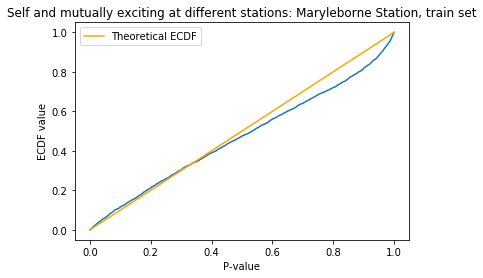

In [386]:
x0,y0 = ecdf(p_values0)
plt.plot(x0,y0)

plt.title("Self and mutually exciting at different stations: Maryleborne Station, train set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

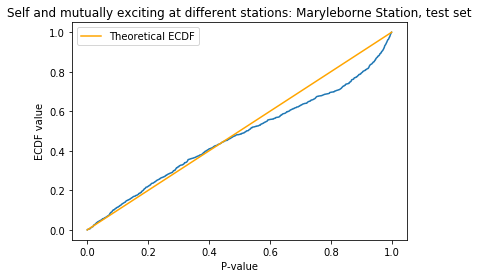

In [387]:
x0,y0 = ecdf(p_values01)
plt.plot(x0,y0)

plt.title("Self and mutually exciting at different stations: Maryleborne Station, test set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

We could optimise SME (multiple stations) for large k in kappa function, so that the model is reduced to SME (single station).

In [388]:
op_seven_log_likelihood_k = lambda param, location_codes, t, k_dep, k_arr, dist, i: - seven_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]), np.exp(param[2])+np.exp(param[3]), k_dep, k_arr, np.exp(param[4]), dist, i)
mle1 = op.minimize(op_seven_log_likelihood_k, x0 = [-4.5, -10, -2.5, 35, -11], method = 'Nelder-Mead', args=(new_loc, t00, np.exp(50), np.exp(50), new_dist, sid))
mle1

 final_simplex: (array([[-4.01397191, -7.75579069, -0.79375278, 67.68608102, -9.23922529],
       [-4.01397209, -7.75579218, -0.79375452, 67.68605036, -9.2392261 ],
       [-4.0139722 , -7.75578246, -0.7937477 , 67.68616592, -9.23922527],
       [-4.01397209, -7.75578663, -0.79375049, 67.68611487, -9.23922617],
       [-4.01397182, -7.75579072, -0.79375248, 67.68608398, -9.23922533],
       [-4.01397211, -7.75578732, -0.79375159, 67.68609495, -9.2392266 ]]), array([16080.98180639, 16080.98180639, 16080.98180639, 16080.98180639,
       16080.98180639, 16080.98180639]))
           fun: 16080.981806391866
       message: 'Optimization terminated successfully.'
          nfev: 385
           nit: 216
        status: 0
       success: True
             x: array([-4.01397191, -7.75579069, -0.79375278, 67.68608102, -9.23922529])

And the KS statistics.

In [390]:
beta_dep1, theta_dep1, beta_arr1, theta_arr1 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[2])+np.exp(mle0.x[3])
k_dep1, k_arr1, lambda_b1 = np.exp(50), np.exp(50), np.exp(mle0.x[4])

t_dep = t00['departure'][sid]
compensator_t1 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t1[j+1] = seven_comp(t_dep[j], new_loc, t00, beta_dep0, theta_dep0, beta_arr0, theta_arr0, k_dep0, k_arr0, lambda_b0, new_dist, sid)

inter_arr_times1 = np.diff(compensator_t1)
p_values1 = np.exp(-inter_arr_times1)

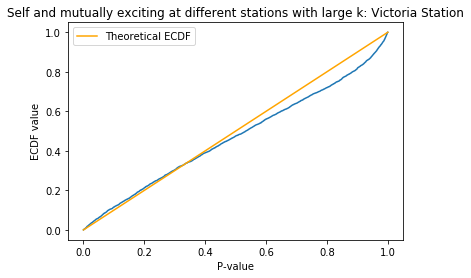

In [391]:
x1,y1 = ecdf(p_values1)
plt.plot(x1,y1)

plt.title("Self and mutually exciting at different stations with large k: Victoria Station")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Now we fit the SME (single station) model. We get the train and test time for Marylebone station only.

In [392]:
t0_dep = train_times['departure'][45]
t0_arr = train_times['arrival'][45]
t0 = {'departure': t0_dep, 'arrival': t0_arr}

t1_dep = test_times['departure'][45]
t1_arr = test_times['arrival'][45]
t1 = {'departure': t1_dep, 'arrival': t1_arr}

And we compute the optimisation.

In [393]:
op_mutual_log_likelihood = lambda param, t: - mutual_log_likelihood(t, np.array([np.exp(param[0]), np.exp(param[1])]), 
                                                                    np.array([np.exp(param[0])+np.exp(param[2]),np.exp(param[1])+np.exp(param[3])]),
                                                                    np.exp(param[4]))

mle2 = op.minimize(op_mutual_log_likelihood, x0 = [0.1, 0.1, 0.1, 0.1, 0.1], method = 'Nelder-Mead', args=(t0,))
mle2

 final_simplex: (array([[-4.01396972, -3.42706328, -7.7557946 , 13.69619013, -9.23921983],
       [-4.01396871, -3.42706159, -7.75586171, 13.69622629, -9.23922124],
       [-4.01397556, -3.42706967, -7.75579594, 13.69620812, -9.23923886],
       [-4.01397557, -3.42706796, -7.75573998, 13.69616736, -9.23922274],
       [-4.01397719, -3.4270698 , -7.75579542, 13.69620634, -9.23923482],
       [-4.01397234, -3.42706055, -7.75585833, 13.6962165 , -9.23920551]]), array([16080.98194873, 16080.98194873, 16080.98194873, 16080.98194873,
       16080.98194873, 16080.98194874]))
           fun: 16080.98194872711
       message: 'Optimization terminated successfully.'
          nfev: 498
           nit: 300
        status: 0
       success: True
             x: array([-4.01396972, -3.42706328, -7.7557946 , 13.69619013, -9.23921983])

And we compute the KS statistics as well as plotting the QQ plots.

In [394]:
beta_dep2, beta_arr2, theta_dep2, theta_arr2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[1]), np.exp(mle2.x[0]) + np.exp(mle2.x[2]), np.exp(mle2.x[1]) + np.exp(mle2.x[3]), np.exp(mle2.x[4])

compensator_t2 = np.zeros(len(t0['departure'])+1)
for i in range(len(t0['departure'])):
    compensator_t2[i+1] = mutual_comp(t0['departure'][i], t0, np.array([beta_dep2, beta_arr2]), np.array([theta_dep2, theta_arr2]), lambda_b2)

inter_arr_times2 = np.diff(compensator_t2)
p_values2 = np.exp(-inter_arr_times2)
ks2 = st.kstest(p_values2, "uniform")
ks_train_mutual.append(ks2.statistic)

In [395]:
ks2

KstestResult(statistic=0.09448867041002051, pvalue=1.3393132864021193e-30)

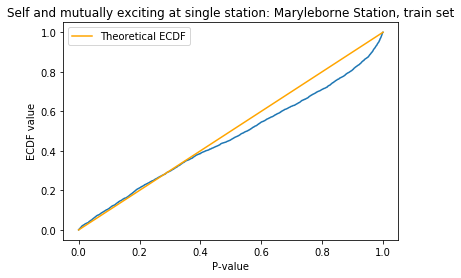

In [396]:
x2,y2 = ecdf(p_values2)
plt.plot(x2,y2)

plt.title("Self and mutually exciting at single station: Maryleborne Station, train set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

In [397]:
beta_dep2, beta_arr2, theta_dep2, theta_arr2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[1]), np.exp(mle2.x[0]) + np.exp(mle2.x[2]), np.exp(mle2.x[1]) + np.exp(mle2.x[3]), np.exp(mle2.x[4])

compensator_t21 = np.zeros(len(t1['departure'])+1)
for i in range(len(t1['departure'])):
    compensator_t21[i+1] = mutual_comp(t1['departure'][i], t1, np.array([beta_dep2, beta_arr2]), np.array([theta_dep2, theta_arr2]), lambda_b2)

inter_arr_times21 = np.diff(compensator_t21)
p_values21 = np.exp(-inter_arr_times21)
ks21 = st.kstest(p_values21, "uniform")
ks_test_mutual.append(ks21.statistic)

In [398]:
ks21

KstestResult(statistic=0.13017714523537027, pvalue=2.1122077763017682e-19)

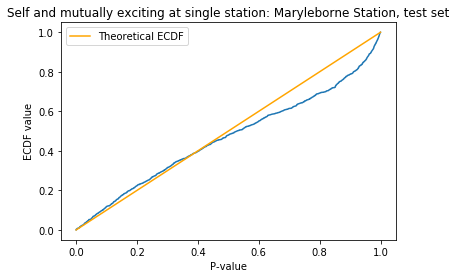

In [399]:
x2,y2 = ecdf(p_values21)
plt.plot(x2,y2)

plt.title("Self and mutually exciting at single station: Maryleborne Station, test set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

For each station, we set threshold at 0.5 miles, and find a neighbourhood of nearby stations. We obtain the list of stations that does not have any nearby stations within 0.5 miles.

In [26]:
thres = 0.5
null_list = []
for k in range(808):
    sid = loc_codes[k] 
    ind = get_station_index(loc_codes, sid)
    
    if len(train_times['departure'][sid]) != 0:
        t0, ind_list, ind1_list = process_times(loc_codes, train_times, sid)
        t1, ind_list, ind1_list = process_times(loc_codes, test_times, sid)
    
    dist_arr = geo_df[f"{ind}"].to_numpy()
    new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
    if len(new_loc) < 2:
        null_list.append(sid)
null_list

[554, 692, 783, 844]

In [27]:
sid=4
ind = get_station_index(loc_codes, sid)
t0, ind_list, ind1_list = process_times(loc_codes, train_times, sid)
t1, ind_list, ind1_list = process_times(loc_codes, test_times, sid)
    
dist_arr = geo_df[f"{ind}"].to_numpy()
df = pd.DataFrame({'col1': list(dist_arr), 'col2': list(loc_codes)})
df=df.sort_values(by=['col1'])
ser = df.iloc[:, 0]
i = ser.searchsorted(1.2, side='right')
df1 = df.iloc[:i]

We implement a function such that, at a given station and a given threshold, it provides the location codes as well as the distances of nearby stations from this station within this threshold distance.

In [28]:
def thres_fun_new(dist, thres, loc_codes):
    new_dist = dist.copy()
    new_loc_codes = np.asarray(loc_codes).copy()
    df = pd.DataFrame({'col1': list(new_dist), 'col2': list(new_loc_codes)})
    df = df.sort_values(by=['col1'])
    
    df = pd.DataFrame({'col1': list(dist_arr), 'col2': list(loc_codes)})
    df=df.sort_values(by=['col1'])
    ser = df.iloc[:, 0]
    i = ser.searchsorted(thres, side='right')
    df1 = df.iloc[:i]
    
    return np.asarray(df1.iloc[:, 0]), np.asarray(df1.iloc[:, 1])

In [29]:
sid=31
ind = get_station_index(loc_codes, sid)

t0, ind_list, ind1_list = process_times(loc_codes, train_times, sid)
t1, ind_list, ind1_list = process_times(loc_codes, test_times, sid)
dist_arr = geo_df[f"{ind}"].to_numpy()
    
thres_fun_new(dist_arr, thres, loc_codes)

(array([0.        , 0.22511404, 0.25584574, 0.25584574, 0.28992731,
        0.2973717 , 0.37419174, 0.45362179, 0.47076422, 0.49887633]),
 array([ 31, 588, 327, 328, 569,  50,  96, 319,  63,  39]))

In [30]:
loc_list = np.array([776,
 550,
 501,
 59,
 410,
 95,
 462,
 699,
 165,
 71,
 496,
 453,
 347,
 768,
 711,
 767,
 482,
 627,
 633,
 337,
 479,
 207,
 729,
 638,
 466,
 820,
 448,
 445,
 228,
 391,
 731,
 432,
 228,
 169,
 562,
 668,
 78,
 453,
 42,
 352,
 147,
 704,
 23,
 532,
 529,
 762,
 423,
 239,
 30,
 197,
 167,
 354,
 187,
 527,
 202,
 159,
 67,
 396,
 72,
 388,
 366,
 436,
 820,
 240,
 704,
 204,
 645,
 28,
 753,
 142,
 350,
 377,
 114,
 209,
 253,
 830,
 728,
 477,
 82,
 541,
 701,
 692,
 76,
 63,
 305,
 63,
 75,
 55,
 122,
 200,
 78,
 799,
 76,
 704,
 640,
 10,
 281,
 771,
 597,
 94])

In [31]:
max_t1 = 0
for i in loc_list:
    max_t1 = max(len(train_times['departure'][i]), max_t1)
    max_t1 = max(len(train_times['arrival'][i]), max_t1)

max_t2 = 0
for i in loc_list:
    max_t2 = max(len(test_times['departure'][i]), max_t2)
    max_t2 = max(len(test_times['arrival'][i]), max_t2)

We randomly select 100 stations, fit both SME (single stations) and SME (multiple stations), and record the KS statistics for both models.

In [35]:
thres = 0.5
train_mutual = []
test_mutual = []
train_seven = []
test_seven = []

p0 = np.zeros((max_t1+1, 100))
p1 = np.zeros((max_t2+1, 100))
p2 = np.zeros((max_t1+1, 100))
p3 = np.zeros((max_t2+1, 100))

for i in range(20): 
    #sid = np.random.choice(loc_codes)
    sid = loc_list[i]
    if len(train_times['departure'][sid]) != 0 and sid not in null_list: #and sid not in loc_list:
        #loc_list.append(sid)
        print(i)
        ind = get_station_index(loc_codes, sid)

        t0, ind_list, ind1_list = process_times(loc_codes, train_times, sid)
        t1, ind_list, ind1_list = process_times(loc_codes, test_times, sid)
    
        dist_arr = geo_df[f"{ind}"].to_numpy()
    
        new_dist, new_loc = thres_fun_new(dist_arr, thres, loc_codes)
        new_loc = new_loc.tolist()
        
        t00 = {}
        t00_dep = {}
        t00_arr = {}
        t01 = {}
        t01_dep = {}
        t01_arr = {}

        for loc in new_loc:
            if loc in t0['departure']:
                t00_dep[loc] = t0['departure'][loc]
                
            if loc in t0['arrival']:
                t00_arr[loc] = t0['arrival'][loc]

            if loc in t1['departure']:
                t01_dep[loc] = t1['departure'][loc]

            if loc in t1['arrival']:
                t01_arr[loc] = t1['arrival'][loc]

            t00['departure'] = t00_dep
            t00['arrival'] = t00_arr
            t01['departure'] = t01_dep
            t01['arrival'] = t01_arr
    
        op_seven_log_likelihood = lambda param, location_codes, t, dist, i: - seven_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[2])+np.exp(param[3]), np.exp(param[4]), 
                                                                                           np.exp(param[5]), np.exp(param[6]), dist, i)
        mle0 = op.minimize(op_seven_log_likelihood, x0 =  [-1.8, -0.3, -5.6, -3.4,  2.5, -0.3, -9],  method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
    
        beta_dep0, theta_dep0, beta_arr0, theta_arr0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[2])+np.exp(mle0.x[3])
        k_dep0, k_arr0, lambda_b0 = np.exp(mle0.x[4]), np.exp(mle0.x[5]), np.exp(mle0.x[6])

        t_dep = t00['departure'][sid]
        compensator_t0 = np.zeros(len(t_dep)+1)
        for j in range(len(t_dep)):
            compensator_t0[j+1] = seven_comp(t_dep[j], new_loc, t00, beta_dep0, theta_dep0, beta_arr0, theta_arr0, k_dep0, k_arr0, lambda_b0, new_dist, sid)

        inter_arr_times0 = np.diff(compensator_t0)
        p_values0 = np.exp(-inter_arr_times0)
        ks0 = st.kstest(p_values0, "uniform")
        train_seven.append(ks0.statistic)
        p0[0:len(t_dep), i] = p_values0
        
        beta_dep0, theta_dep0, beta_arr0, theta_arr0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[2])+np.exp(mle0.x[3])
        k_dep0, k_arr0, lambda_b0 = np.exp(mle0.x[4]), np.exp(mle0.x[5]), np.exp(mle0.x[6])

        t_dep = t01['departure'][sid]
        compensator_t01 = np.zeros(len(t_dep)+1)
        for j in range(len(t_dep)):
            compensator_t01[j+1] = seven_comp(t_dep[j], new_loc, t01, beta_dep0, theta_dep0, beta_arr0, theta_arr0, k_dep0, k_arr0, lambda_b0, new_dist, sid)

        inter_arr_times01 = np.diff(compensator_t01)
        p_values01 = np.exp(-inter_arr_times01)
        ks1 = st.kstest(p_values01, "uniform")
        test_seven.append(ks1.statistic)
        p1[0:len(t_dep), i] = p_values01
        
        t0_dep = train_times['departure'][sid]
        t0_arr = train_times['arrival'][sid]
        t0 = {'departure': t0_dep, 'arrival': t0_arr}

        t1_dep = test_times['departure'][sid]
        t1_arr = test_times['arrival'][sid]
        t1 = {'departure': t1_dep, 'arrival': t1_arr}
        op_mutual_log_likelihood = lambda param, t: - mutual_log_likelihood(t, np.array([np.exp(param[0]), np.exp(param[1])]), 
                                                                    np.array([np.exp(param[0])+np.exp(param[2]),np.exp(param[1])+np.exp(param[3])]),
                                                                    np.exp(param[4]))

        mle2 = op.minimize(op_mutual_log_likelihood, x0 =  [-1, -4, -1, -4, 6], method = 'Nelder-Mead', args=(t0,))
        beta_dep2, beta_arr2, theta_dep2, theta_arr2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[1]), np.exp(mle2.x[0]) + np.exp(mle2.x[2]), np.exp(mle2.x[1]) + np.exp(mle2.x[3]), np.exp(mle2.x[4])

        compensator_t2 = np.zeros(len(t0['departure'])+1)
        for j in range(len(t0['departure'])):
            compensator_t2[j+1] = mutual_comp(t0['departure'][j], t0, np.array([beta_dep2, beta_arr2]), np.array([theta_dep2, theta_arr2]), lambda_b2)

        inter_arr_times2 = np.diff(compensator_t2)
        p_values2 = np.exp(-inter_arr_times2)
        ks2 = st.kstest(p_values2, "uniform")
        train_mutual.append(ks2.statistic)
        p2[0:len(t0['departure']), i] = p_values2
        
        beta_dep2, beta_arr2, theta_dep2, theta_arr2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[1]), np.exp(mle2.x[0]) + np.exp(mle2.x[2]), np.exp(mle2.x[1]) + np.exp(mle2.x[3]), np.exp(mle2.x[4])

        compensator_t21 = np.zeros(len(t1['departure'])+1)
        for j in range(len(t1['departure'])):
            compensator_t21[j+1] = mutual_comp(t1['departure'][j], t1, np.array([beta_dep2, beta_arr2]), np.array([theta_dep2, theta_arr2]), lambda_b2)

        inter_arr_times21 = np.diff(compensator_t21)
        p_values21 = np.exp(-inter_arr_times21)
        ks21 = st.kstest(p_values21, "uniform")
        test_mutual.append(ks21.statistic)
        p3[0:len(t1['departure']), i] = p_values21
        
        print(ks0.statistic)
        print(ks2.statistic)

0
0.036074814329033644
0.049608971808690616
1
0.03319161402865245
0.04188947745156241
2
0.02600621566789696
0.03125352437993112
4
0.02146899594296625
0.04010016663323357
5
0.02888250379684648
0.026555798151527088
6
0.027089674476916792
0.033804135450969164
7
0.027462231290872552
0.04578102862126643
8
0.04709379680383197
0.053350045857978756
9
0.031755350461926346
0.036086577456723556
10
0.03122376691065354
0.03318966938160578
11
0.033112350649502686
0.0463725811415574
12
0.032786572295657734
0.04214640164347966
13
0.03808160059935062
0.04422299630095228
14
0.025638956062088214
0.04049854758438598
15
0.05617429714073008
0.079349696406176
16
0.05280642951217368
0.04992940947470981
17
0.04840241065873707
0.05534296283542539
18
0.023148471239160695
0.02714800974228143
19
0.026663711719838668
0.040130589062916944


In [37]:
train_mutual

[0.049608971808690616,
 0.04188947745156241,
 0.03125352437993112,
 0.04010016663323357,
 0.026555798151527088,
 0.033804135450969164,
 0.04578102862126643,
 0.053350045857978756,
 0.036086577456723556,
 0.03318966938160578,
 0.0463725811415574,
 0.04214640164347966,
 0.04422299630095228,
 0.04049854758438598,
 0.079349696406176,
 0.04992940947470981,
 0.05534296283542539,
 0.02714800974228143,
 0.040130589062916944]

In [39]:
train_seven

[0.036074814329033644,
 0.03319161402865245,
 0.02600621566789696,
 0.02146899594296625,
 0.02888250379684648,
 0.027089674476916792,
 0.027462231290872552,
 0.04709379680383197,
 0.031755350461926346,
 0.03122376691065354,
 0.033112350649502686,
 0.032786572295657734,
 0.03808160059935062,
 0.025638956062088214,
 0.05617429714073008,
 0.05280642951217368,
 0.04840241065873707,
 0.023148471239160695,
 0.026663711719838668]

In [43]:
np.mean(train_seven)

0.034055987557201926

In [40]:
test_mutual

[0.05599009424113921,
 0.02746184389015982,
 0.03021242765354415,
 0.0415945599613588,
 0.018491863324619884,
 0.03200286049444662,
 0.040355149094431164,
 0.05082011975467621,
 0.0428051203796419,
 0.06836234354341603,
 0.038457939036611766,
 0.04370374880562239,
 0.03948168718677292,
 0.031063724920022295,
 0.09545500185517092,
 0.05495418298354482,
 0.0656162397876493,
 0.02950423025360155,
 0.04319384877169141]

In [41]:
test_seven

[0.06721955693684667,
 0.022281971257771316,
 0.030999649971678367,
 0.033913173468811175,
 0.0313705546826169,
 0.02778620489175143,
 0.028252634117867464,
 0.027202395175699556,
 0.044749779997927175,
 0.05807270738260617,
 0.03167152770818493,
 0.029066630535659832,
 0.03073682199736716,
 0.03293933046564784,
 0.08143202851055964,
 0.04865428275332262,
 0.07691805364092663,
 0.017800036902212435,
 0.029943587681865724]

In [126]:
train_seven

[0.031407416935973986,
 0.019833771730824623,
 0.02109951763788326,
 0.01901680827980362,
 0.02239687184201372,
 0.023736537907607824,
 0.024760541268071423,
 0.028432348127588325,
 0.0220506770638228,
 0.02114890174439016,
 0.0268202151997331,
 0.023405895797027565,
 0.036500467782988044,
 0.0287849880204889,
 0.020787373791148367,
 0.030203230368015477,
 0.01634901905248881,
 0.02311533995412457,
 0.03186170969836383,
 0.030054628271245498,
 0.033116927739131,
 0.016317979134524152,
 0.040556951014427356,
 0.018863629950990446,
 0.048316993625634796,
 0.018816594812841536,
 0.053756870788546296,
 0.019365454635953905,
 0.053166913764084445,
 0.035467856655670205,
 0.036340410774251874,
 0.014651758688205008,
 0.024573233628827684,
 0.029132476189725975,
 0.024650568247040927,
 0.02368615006012259,
 0.04202080132206709,
 0.030116924464884842,
 0.029729451113388428,
 0.02724846757281507,
 0.015579279878440266,
 0.037893693981361776,
 0.031264372551274344,
 0.03906773909622541,
 0.02045

A box plot of the KS statistics for both models.

In [ ]:
plt.boxplot(train_mutual);
plt.boxplot(train_seven)

We find the difference between the KS statistics of both models.

In [81]:
train_diff = np.array(train_mutual) - np.array(train_seven)
train_sign = np.sign(train_diff)
test_diff = np.array(test_mutual) - np.array(test_seven)
test_sign = np.sign(test_diff)

And find the number of stations that perform better with SME (multiple stations) model.

In [82]:
from collections import Counter
Counter(train_sign)

Counter({1.0: 85, -1.0: 15})

In [83]:
from collections import Counter
Counter(test_sign)

Counter({1.0: 67, -1.0: 33})

The relative ks scores will be $\frac{KS_{mutual} - KS_{seven}}{KS_{mutual}}$

In [84]:
rel_train_ks = (np.array(train_mutual) - np.array(train_seven)) / np.array(train_mutual)
rel_test_ks = (np.array(test_mutual) - np.array(test_seven)) / np.array(test_mutual)

We now want to plot the scatter plot of station coordinates of the randomly selected 100 stations, labelling the points by the difference in their ks scores.

In [85]:
station_data = pd.read_csv("./santander_locations.csv")

In [86]:
d = {'loc': loc_list, 'train': rel_train_ks, 'test': rel_test_ks}
df1 = pd.DataFrame(data=d)
df1 = df1.sort_values(by=['loc'])
df1 = df1.drop_duplicates(subset=['loc'])

In [87]:
df1

,loc,train,test
0,4,0.337431,0.286633
1,5,0.187501,0.309024
2,32,0.234238,0.237693
3,37,0.230694,-0.668520
4,40,0.402849,0.170615
...,...,...,...
95,810,0.164646,0.083254
96,811,0.285257,0.243136
97,812,-1.084093,-1.186325
98,821,0.063608,0.347652


In [88]:
mask = station_data['Station.Id'].isin(loc_list)
df = station_data.loc[mask]
df['train.ks'] = list(df1['train'])
df['test.ks'] = list(df1['test'])
df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Station.Id,StationName,longitude,latitude,Easting,Northing,train.ks,test.ks
3,4,"St. Chad's Street, King's Cross",-0.120974,51.530100,530436.760,182911.990,0.337431,0.286633
4,5,"Sedding Street, Sloane Square",-0.156876,51.493100,528051.649,178742.097,0.187501,0.309024
31,32,"Leonard Circus, Shoreditch",-0.084439,51.524700,532986.420,182381.310,0.234238,0.237693
35,37,"Penywern Road, Earl's Court",-0.192369,51.491600,525590.340,178509.690,0.230694,-0.668520
38,40,"Commercial Street, Shoreditch",-0.075579,51.521300,533611.070,182016.510,0.402849,0.170615
...,...,...,...,...,...,...,...,...
778,810,"Tate Modern, Bankside",-0.098885,51.506721,532037.270,180356.310,0.164646,0.083254
779,811,"Westferry Circus, Canary Wharf",-0.027776,51.505697,536975.000,180373.000,0.285257,0.243136
780,812,"Here East North, Queen Elizabeth Olympic Park",-0.022627,51.548724,537203.027,185167.369,-1.084093,-1.186325
789,821,"Battersea Power Station, Battersea Park",-0.147702,51.483516,528714.824,177688.956,0.063608,0.347652


In [89]:
max(list(df['train.ks']))

0.6855100261958077

In [90]:
min(list(df['train.ks']))

-1.0840926660052044

In [91]:
from matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
cols = np.array(cmap((df['train.ks'] + max(np.abs(df['train.ks']))) / (2 * max(np.abs(df['train.ks'])))))[:,:3]

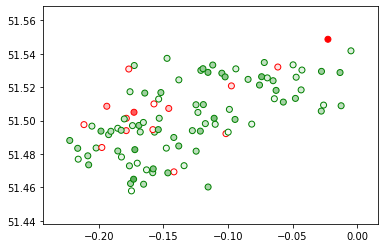

In [120]:
##import seaborn as sns
##sns
edges = np.array(['red','green'])[np.array(df['train.ks'] > 0).astype(int)]
plt.scatter(df['longitude'], df['latitude'], c=cols, edgecolor = edges)##palette=cmap, edgecolor = 'black')
plt.savefig('pdf1.pdf')

In [93]:
#edges = np.array(['red','green'])[np.array(df['train.ks'] > 0).astype(int)]

In [94]:
(#df - min(df)) / (max(df) - min(df))

SyntaxError: unexpected EOF while parsing (<ipython-input-94-421ffa1037fc>, line 1)

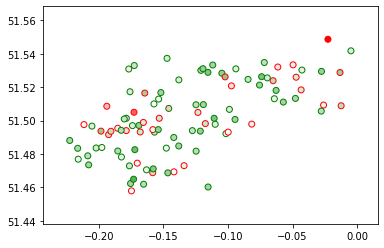

In [121]:
#sns.scatterplot('longitude', 'latitude', data=df, hue=df['test.ks'], palette='Spectral')
edges = np.array(['red','green'])[np.array(df['test.ks'] > 0).astype(int)]
plt.scatter(df['longitude'], df['latitude'], c=cols, edgecolor = edges)
plt.savefig('pdf2.pdf')

We plot the ks scores of each station over the log of the number of departure events at each station.

In [96]:
dep_len_train_all = []
dep_len_test_all = []
dep_len_train_id = []
dep_len_test_id = []
arr_len_train_all = []
arr_len_test_all = []
arr_len_train_id = []
arr_len_test_id = []

for i in range(len(loc_list)):
    sid = loc_list[i]
    ind = get_station_index(loc_codes, sid)
    train_dep = 0
    test_dep = 0
    train_arr = 0
    test_arr = 0

    t0, ind_list, ind1_list = process_times(loc_codes, train_times, sid)
    t1, ind_list, ind1_list = process_times(loc_codes, test_times, sid)
    
    dist_arr = geo_df[f"{ind}"].to_numpy()
    
    new_dist, new_loc = thres_fun_new(dist_arr, thres, loc_codes)
    new_loc = new_loc.tolist()

    for loc in new_loc:
        if loc in t0['departure']:
            train_dep += len(t0['departure'][loc])
                
        if loc in t0['arrival']:
            train_arr = len(t0['arrival'][loc])

        if loc in t1['departure']:
            test_dep = len(t1['departure'][loc])

        if loc in t1['arrival']:
            test_arr = len(t1['arrival'][loc])

    dep_len_train_all.append(train_dep)
    dep_len_test_all.append(test_dep)
    arr_len_train_all.append(train_arr)
    arr_len_test_all.append(test_arr)

    dep_len_train_id.append(len(t0['departure'][sid]))
    dep_len_test_id.append(len(t0['arrival'][sid]))
    arr_len_train_id.append(len(t1['departure'][sid]))
    arr_len_test_id.append(len(t1['arrival'][sid]))
    
log_dep_train_all = np.log(np.array(dep_len_train_all))
log_dep_test_all = np.log(np.array(dep_len_test_all))
log_arr_train_all = np.log(np.array(arr_len_train_all))
log_arr_test_all = np.log(np.array(arr_len_test_all))
    
log_dep_train = np.log(np.array(dep_len_train_id))
log_dep_test = np.log(np.array(dep_len_test_id))
log_arr_train = np.log(np.array(arr_len_train_id))
log_arr_test = np.log(np.array(arr_len_test_id))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log


In [97]:
d1 = {'loc': loc_list, 'train.ks': rel_train_ks, 
      'test.ks': rel_test_ks, 'train.dep.all': log_dep_train_all, 
      'train.arr.all': log_arr_train_all, 
      'test.dep.all': log_dep_test_all, 'test.arr.all': log_arr_test_all,
      'train.dep.id': log_dep_train, 'test.dep.id': log_dep_test,
     'train.arr.id': log_arr_train, 'test.arr.id': log_arr_test}
df2 = pd.DataFrame(data=d1)
df2 = df2.sort_values(by=['loc'])
df2 = df2.drop_duplicates(subset=['loc'])

In [98]:
df2

,loc,train.ks,test.ks,train.dep.all,train.arr.all,test.dep.all,test.arr.all,train.dep.id,test.dep.id,train.arr.id,test.arr.id
0,4,0.337431,0.286633,10.306282,-inf,-inf,-inf,7.517521,7.516977,6.434547,6.432940
1,5,0.187501,0.309024,9.805654,7.825645,6.761573,6.759255,8.716536,8.716208,7.610853,7.610358
2,32,0.234238,0.237693,10.624128,7.799753,6.603944,6.603944,8.494743,8.494334,7.346655,7.346010
3,37,0.230694,-0.668520,10.189531,7.853993,6.731018,6.729824,8.358197,8.357963,7.195937,7.193686
4,40,0.402849,0.170615,10.859114,7.645876,6.625392,6.624065,8.242493,8.242230,7.065613,7.064759
...,...,...,...,...,...,...,...,...,...,...,...
95,810,0.164646,0.083254,10.142308,6.836259,5.726848,5.726848,7.989899,7.989560,6.978214,6.976348
96,811,0.285257,0.243136,9.718903,8.719971,7.612831,7.612337,8.780480,8.780019,7.631432,7.630461
97,812,-1.084093,-1.186325,9.241548,-inf,-inf,-inf,7.959276,7.957177,6.776507,6.774224
98,821,0.063608,0.347652,10.011759,7.693026,6.674561,6.674561,9.314070,9.313979,8.195058,8.194229


Scatter plot of all departure training events in the neighborhood of each station.

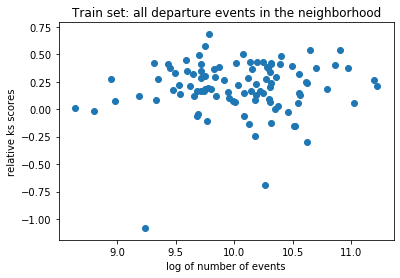

In [122]:
#sns.scatterplot('train.len', 'train.ks', data=df, hue=df['train.ks'])
x = df2['train.dep.all']
y = df2['train.ks']
plt.scatter(x, y)

#a, b = np.polyfit(x, y, 1)
#plt.plot(x, a*x+b)        
#plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Train set: all departure events in the neighborhood')
plt.savefig('pdf3.pdf')

In [100]:
yhat = np.poly1d(np.polyfit(x, y, 1))(x)
MSE = 1/len(y) * np.sum((yhat - y)**2)
MSE

0.05905650156105103

Scatter plot of the departure train events of each station only.

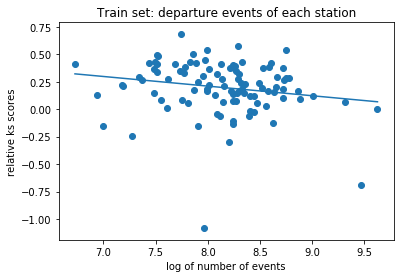

In [101]:
x = df2['train.dep.id']
y = df2['train.ks']
plt.scatter(x, y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Train set: departure events of each station')
plt.show()

Scatter plot of all departure test events in the neighbourhood of each station.

In [102]:
yhat = np.poly1d(np.polyfit(x, y, 1))(x)
MSE = 1/len(y) * np.sum((yhat - y)**2)
MSE

0.05739187112297165

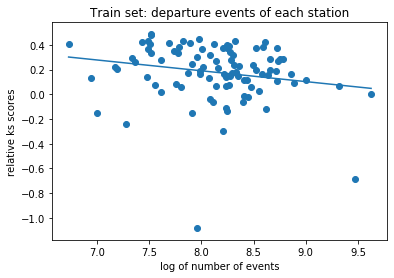

In [103]:
#Remove anomalies
indice = np.where(y.to_numpy() < 0.5)[0].tolist()
x_new = x.to_numpy()[indice]
y_new = y.to_numpy()[indice]
plt.scatter(x_new, y_new)
plt.plot(np.unique(x_new), np.poly1d(np.polyfit(x_new, y_new, 1))(np.unique(x_new)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Train set: departure events of each station')
plt.show()

In [104]:
yhat = np.poly1d(np.polyfit(x_new, y_new, 1))(x_new)
MSE = 1/len(y_new) * np.sum((yhat - y_new)**2)
MSE

0.05265923926757232

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


LinAlgError: SVD did not converge in Linear Least Squares

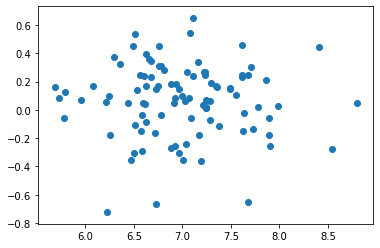

In [124]:
#sns.scatterplot('train.len', 'train.ks', data=df, hue=df['train.ks'])
x = df2['test.dep.all']
y = df2['test.ks']
plt.scatter(x, y)

plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Test set: departure events of each station')
plt.savefig('pdf4.pdf')

Scatter plot of the departure test events of each station only.

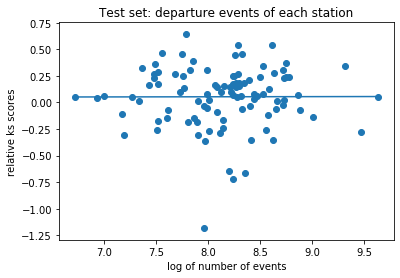

In [106]:
#sns.scatterplot('train.len', 'train.ks', data=df, hue=df['train.ks'])
x = df2['test.dep.id']
y = df2['test.ks']
plt.scatter(x, y)

#a, b = np.polyfit(x, y, 1)
#plt.plot(x, a*x+b)        
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Test set: departure events of each station')
plt.show()

In [107]:
yhat = np.poly1d(np.polyfit(x, y, 1))(x)
MSE = 1/len(y) * np.sum((yhat - y)**2)
MSE

0.07969669088942045

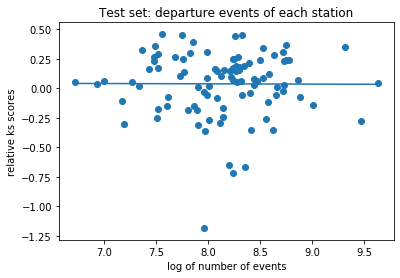

In [108]:
#Remove anomalies
indice = np.where(y.to_numpy() < 0.5)[0].tolist()
x_new = x.to_numpy()[indice]
y_new = y.to_numpy()[indice]
plt.scatter(x_new, y_new)
plt.plot(np.unique(x_new), np.poly1d(np.polyfit(x_new, y_new, 1))(np.unique(x_new)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Test set: departure events of each station')
plt.show()

In [109]:
yhat = np.poly1d(np.polyfit(x_new, y_new, 1))(x_new)
MSE = 1/len(y_new) * np.sum((yhat - y_new)**2)
MSE

0.07336700595931867

Scatter plot of all arrival training events in the neighborhood of each station.

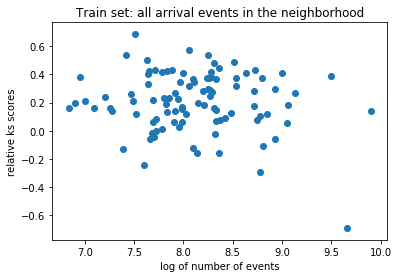

In [110]:
#sns.scatterplot('train.len', 'train.ks', data=df, hue=df['train.ks'])
x = df2['train.arr.all']
y = df2['train.ks']
plt.scatter(x, y)

#a, b = np.polyfit(x, y, 1)
#plt.plot(x, a*x+b)        
#plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Train set: all arrival events in the neighborhood')
plt.show()

Scatter plot of the arrival train events of each station only.

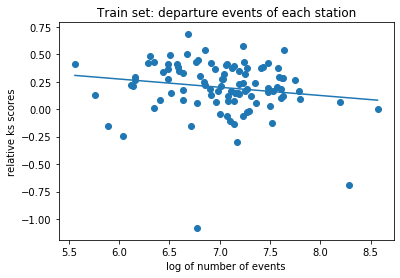

In [111]:
#sns.scatterplot('train.len', 'train.ks', data=df, hue=df['train.ks'])
x = df2['train.arr.id']
y = df2['train.ks']
plt.scatter(x, y)

#a, b = np.polyfit(x, y, 1)
#plt.plot(x, a*x+b)        
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Train set: departure events of each station')
plt.show()

In [112]:
yhat = np.poly1d(np.polyfit(x, y, 1))(x)
MSE = 1/len(y) * np.sum((yhat - y)**2)
MSE

0.057922159642566876

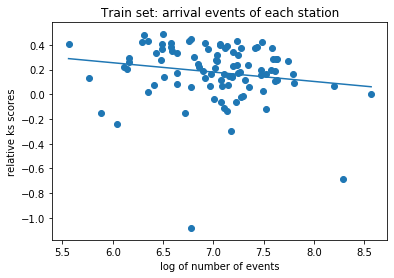

In [113]:
#Remove anomalies
indice = np.where(y.to_numpy() < 0.5)[0].tolist()
x_new = x.to_numpy()[indice]
y_new = y.to_numpy()[indice]
plt.scatter(x_new, y_new)
plt.plot(np.unique(x_new), np.poly1d(np.polyfit(x_new, y_new, 1))(np.unique(x_new)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Train set: arrival events of each station')
plt.show()

In [114]:
yhat = np.poly1d(np.polyfit(x_new, y_new, 1))(x_new)
MSE = 1/len(y_new) * np.sum((yhat - y_new)**2)
MSE

0.0531669281286845

Scatter plot of all arrival test events in the neighbourhood of each station.

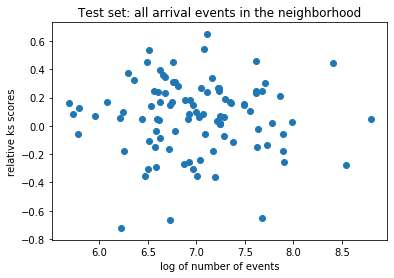

In [115]:
x = df2['test.arr.all']
y = df2['test.ks']
plt.scatter(x, y)
#plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Test set: all arrival events in the neighborhood')
plt.show()

Scatter plot of the arrival test events of each station only.

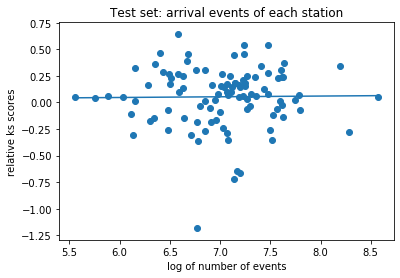

In [116]:
x = df2['test.arr.id']
y = df2['test.ks']
plt.scatter(x, y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Test set: arrival events of each station')
plt.show()

In [117]:
yhat = np.poly1d(np.polyfit(x, y, 1))(x)
MSE = 1/len(y) * np.sum((yhat - y)**2)
MSE

0.07968455736274842

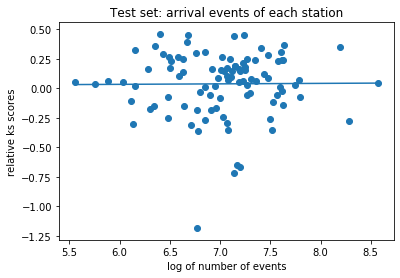

In [118]:
#Remove anomalies
indice = np.where(y.to_numpy() < 0.5)[0].tolist()
x_new = x.to_numpy()[indice]
y_new = y.to_numpy()[indice]
plt.scatter(x_new, y_new)
plt.plot(np.unique(x_new), np.poly1d(np.polyfit(x_new, y_new, 1))(np.unique(x_new)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Test set: arrival events of each station')
plt.show()

In [119]:
yhat = np.poly1d(np.polyfit(x_new, y_new, 1))(x_new)
MSE = 1/len(y_new) * np.sum((yhat - y_new)**2)
MSE

0.07336401265607644